# Table of Contents
 <p><div class="lev1"><a href="#Initialize-Environment-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialize Environment</a></div><div class="lev1"><a href="#Subgraph-of-Brain-Systems-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Subgraph of Brain Systems</a></div><div class="lev2"><a href="#Focal-vs-Distributed-Subgraphs-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Focal vs Distributed Subgraphs</a></div><div class="lev2"><a href="#Formulate-ROI-Dict-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Formulate ROI Dict</a></div><div class="lev2"><a href="#Convert-ROI-Subgraphs-to-Brain-System-Subgraphs-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Convert ROI Subgraphs to Brain System Subgraphs</a></div><div class="lev2"><a href="#Between-Task-Subgraph-Contrast-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Between-Task Subgraph Contrast</a></div><div class="lev2"><a href="#Within-Task-Subgraph-Contrast-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Within-Task Subgraph Contrast</a></div><div class="lev2"><a href="#Subgraph-Expression-vs-Behavior-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Subgraph Expression vs Behavior</a></div><div class="lev3"><a href="#Load-Behavioral-Data-2.6.1"><span class="toc-item-num">2.6.1&nbsp;&nbsp;</span>Load Behavioral Data</a></div><div class="lev3"><a href="#Predicting-Interference-RT-(Hi)-2.6.2"><span class="toc-item-num">2.6.2&nbsp;&nbsp;</span>Predicting Interference RT (Hi)</a></div><div class="lev3"><a href="#Predicting-Cost-RT-(Hi-Lo)-2.6.3"><span class="toc-item-num">2.6.3&nbsp;&nbsp;</span>Predicting Cost RT (Hi-Lo)</a></div><div class="lev3"><a href="#Predicting-Interference-Accuracy-(Hi)-2.6.4"><span class="toc-item-num">2.6.4&nbsp;&nbsp;</span>Predicting Interference Accuracy (Hi)</a></div><div class="lev3"><a href="#Predicting-Cost-Accuracy-(Hi-Lo)-2.6.5"><span class="toc-item-num">2.6.5&nbsp;&nbsp;</span>Predicting Cost Accuracy (Hi-Lo)</a></div>

# Initialize Environment

In [1]:
try:
    %load_ext autoreload
    %autoreload 2
    
except:
    print 'NOT IPYTHON'

from __future__ import division
from IPython.display import display

import os
import sys
import glob
import json
import subprocess

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as io
import h5py
import matplotlib.pyplot as plt
from matplotlib import rcParams

import fig_plotting
rcParams = fig_plotting.update_rcparams(rcParams)

import scipy.stats as stats

os.chdir('../')
import Codebase
conv_adj_matr_to_cfg_matr = Codebase.Networks.configuration.convert_adj_matr_to_cfg_matr
conv_cfg_vec_to_adj_matr = Codebase.Networks.configuration.convert_conn_vec_to_adj_matr
os.chdir('./Analysis_Notebooks/')

path_Remotes = '/Users/akhambhati/Remotes'
path_CoreData = path_Remotes + '/CORE.fMRI_cogcontrol.medaglia'
path_RsrchData = path_Remotes + '/RSRCH.NMF_CogControl'
path_InpData = path_RsrchData + '/e02-FuncSubg'
path_ExpData = path_RsrchData + '/e04-FuncSubg_Dynamics'

for path in [path_CoreData, path_RsrchData, path_ExpData]:
    if not os.path.exists(path):
        print('Path: {}, does not exist'.format(path))
        os.makedirs(path)

/Users/akhambhati/Developer/miniconda2/envs/cb-nmfsubnet/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Subgraph of Brain Systems

In [2]:
df_nmf = np.load('{}/NMF_Consensus.npz'.format(path_InpData), mmap_mode='r')
fac_subnet = df_nmf['fac_subnet']
fac_coef = df_nmf['fac_coef']
n_fac = fac_subnet.shape[0]
n_conn = fac_subnet.shape[1]
n_obs = fac_coef.shape[1]

## Focal vs Distributed Subgraphs

(0, 54)

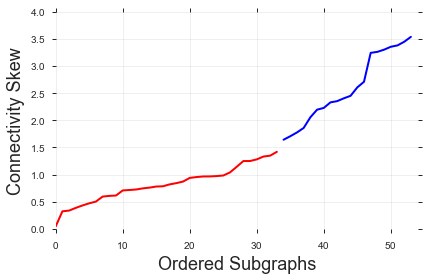

In [129]:
real_subg_skew = np.array([stats.skew(subg) for subg in fac_subnet])
real_ix = np.argsort(real_subg_skew)

n_null = 10000
#coef_dist = fac_coef.reshape(-1)
#rnd_coef = np.array([np.random.permutation(coef_dist)[:54] for i in xrange(n_null)])
rnd_coef = np.random.uniform(size=(n_null, n_fac))
rnd_subnet = np.dot(rnd_coef, fac_subnet)

rnd_subg_skew = np.array([stats.skew(subg) for subg in rnd_subnet])
rnd_ix = np.argsort(rnd_subg_skew)

thresh = np.percentile(rnd_subg_skew, 100)
low_ix = np.flatnonzero(real_subg_skew[real_ix] <= thresh)
high_ix = np.flatnonzero(real_subg_skew[real_ix] > thresh)

%matplotlib inline
plt.figure()
ax = plt.subplot(111)
ax.plot(low_ix, real_subg_skew[real_ix][low_ix], color='r')
ax.plot(high_ix, real_subg_skew[real_ix][high_ix], color='b')
ax.set_xlabel('Ordered Subgraphs')
ax.set_ylabel('Connectivity Skew')
ax.set_xlim([0, n_fac])

## Formulate ROI Dict

In [3]:
df_parcel = pd.read_csv('{}/LausanneScale125.csv'.format(path_CoreData))

all_roi_names = []

roi_dict = {}
for lbl_id, lbl_roi, lbl_hemi in zip(df_parcel.Label_ID, df_parcel.ROI, df_parcel.Hemisphere):
    roi_name = '{}_{}'.format(lbl_hemi, lbl_roi.split('_')[0])
    #roi_name = lbl_roi.split('_')[0]
    
    if roi_name not in all_roi_names:
        all_roi_names.append(roi_name)

    try:
        roi_dict[roi_name]
    except KeyError:
        roi_dict[roi_name] = []

    roi_dict[roi_name].append(lbl_id-1)
n_roi = len(all_roi_names)
n_conn_roi = int(n_roi*(n_roi-1)*0.5)

## Convert ROI Subgraphs to Brain System Subgraphs

In [4]:
bs_fac_subnet = np.zeros((n_fac, n_conn_roi))
for fac_i, subg in enumerate(fac_subnet):
    adj = conv_cfg_vec_to_adj_matr(subg)
    
    tmp_subnet = np.zeros((1, n_roi, n_roi))
    for ij_ii, ij_roi in enumerate(all_roi_names):
        for ik_ii, ik_roi in enumerate(all_roi_names):
            
            mean_conn = adj[roi_dict[ij_roi], :][:, roi_dict[ik_roi]].mean()
            tmp_subnet[0, ij_ii, ik_ii] = mean_conn
    bs_fac_subnet[fac_i, :] = conv_adj_matr_to_cfg_matr(tmp_subnet)[0, :]

## Between-Task Subgraph Contrast

0.0023148148
****************************** Subgraph 10 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_cuneus
    LH_lingual
    RH_pericalcarine
    RH_lingual

    Pos-Stroop-Navon: ts: -4.530177 pval: 0.000108 sig: *
    Neg-Stroop-Navon: ts: 2.495176 pval: 0.019002 sig: 


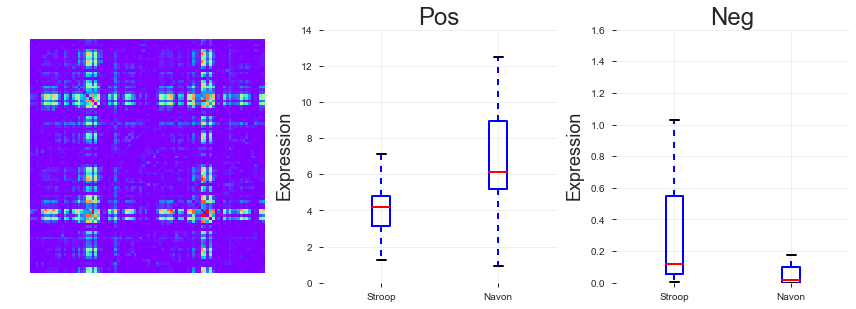





****************************** Subgraph 21 ******************************
    LH_lateraloccipital
    LH_fusiform
    RH_lateraloccipital
    RH_fusiform
    LH_precentral
    LH_superiorparietal

    Pos-Stroop-Navon: ts: -9.508163 pval: 0.000000 sig: *
    Neg-Stroop-Navon: ts: 2.471555 pval: 0.020050 sig: 


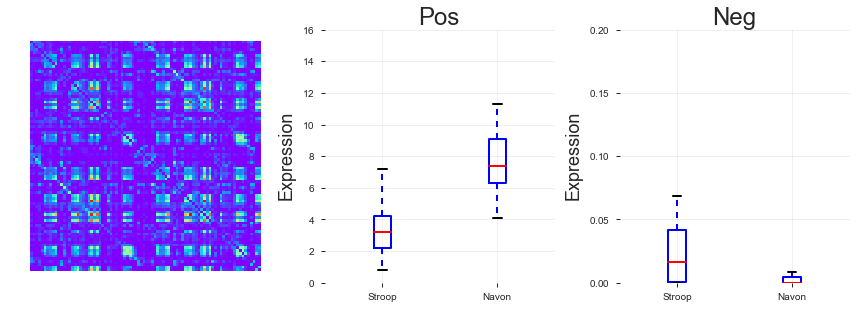





****************************** Subgraph 44 ******************************
    RH_rostralmiddlefrontal
    RH_parsorbitalis
    RH_caudalmiddlefrontal
    RH_middletemporal
    RH_inferiorparietal
    RH_parsopercularis

    Pos-Stroop-Navon: ts: -4.040507 pval: 0.000398 sig: *
    Neg-Stroop-Navon: ts: 4.546867 pval: 0.000103 sig: *


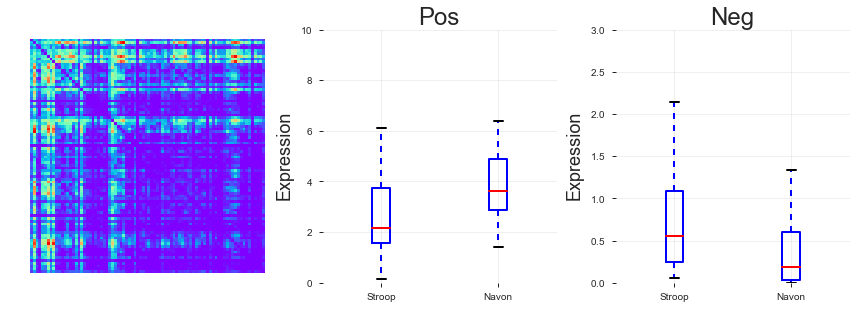





****************************** Subgraph 48 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_pericalcarine
    RH_cuneus
    LH_lingual
    RH_lingual

    Pos-Stroop-Navon: ts: 4.560308 pval: 0.000099 sig: *
    Neg-Stroop-Navon: ts: -1.275796 pval: 0.212895 sig: 


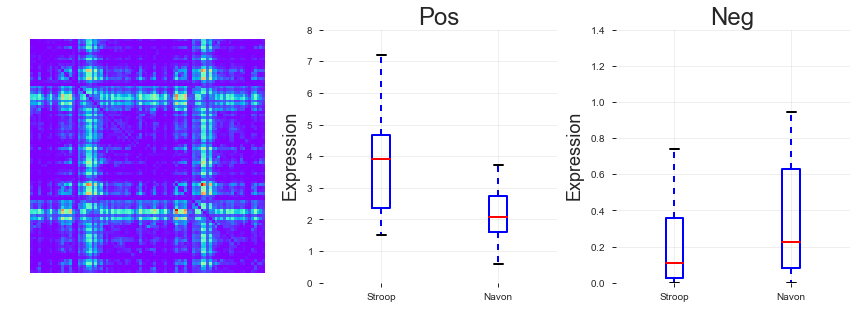

In [50]:
%matplotlib inline

path_cfg_expr = glob.glob('{}/NMF_Optimization.CfgMatr.npz'.format(path_InpData))[0]
df_cfg = np.load(path_cfg_expr, mmap_mode='r')
cfg_key = df_cfg['cfg_key']
key_grp = {'Pos': {'Stroop': ['adj_hi_pos_Stroop', 'adj_lo_pos_Stroop'],
                   'Navon': ['adj_hi_pos_Navon', 'adj_lo_pos_Navon']},
           'Neg': {'Stroop': ['adj_hi_neg_Stroop', 'adj_lo_neg_Stroop'],
                   'Navon': ['adj_hi_neg_Navon', 'adj_lo_neg_Navon']}}
grp_order = ['Pos', 'Neg']
key_order = ['Stroop', 'Navon']

sel_fac_ix = np.arange(n_fac)

# Populate plot database
plot_list = []
for fac_ii in sel_fac_ix:
    plot_dict = {'subgraph': conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]),
                 'subplot': []}
                 
    for grp in grp_order: #key_grp.keys():
        subplot_dict = {'title': grp,
                        'xlabel': [],
                        'distrib': [],
                        'stats': []}
        
        for key in key_order: #key_grp[grp].keys():
            key_hi_ix = np.flatnonzero(cfg_key == key_grp[grp][key][0])
            key_lo_ix = np.flatnonzero(cfg_key == key_grp[grp][key][1])
            
            subj_hi = fac_coef[fac_ii, key_hi_ix].reshape(-1, 6)
            subj_lo = fac_coef[fac_ii, key_lo_ix].reshape(-1, 6)

            mean_subj_coef = 0.5*(np.mean(subj_hi, axis=1) + np.mean(subj_lo, axis=1))
            
            subplot_dict['xlabel'].append(key)
            subplot_dict['distrib'].append(mean_subj_coef)
        
        for key_pair in [[0,1]]:
            ts, pv = stats.ttest_rel(subplot_dict['distrib'][key_pair[0]],
                                     subplot_dict['distrib'][key_pair[1]])      
            subplot_dict['stats'].append({'name': '{}-{}'.format(subplot_dict['xlabel'][key_pair[0]],
                                                                 subplot_dict['xlabel'][key_pair[1]]),
                                          'tstat': ts,
                                          'pval': pv,
                                          'sig': ''})
            
        plot_dict['subplot'].append(subplot_dict)
    plot_list.append(plot_dict)

# Benjamini-Hochberg Multiple Comparisons
all_pval = np.sort([fac_stat['pval']
                    for fac_plot in plot_list
                    for fac_subp in fac_plot['subplot']
                    for fac_stat in fac_subp['stats']])[::-1]
alpha = 0.05
n_comp = len(all_pval)
for ix, i in enumerate(range(n_comp, 0, -1)):
    adj_alpha = i/n_comp*alpha
    if all_pval[ix] < adj_alpha:
        break
print('%0.10f' % adj_alpha)

# Re-adjust significant indicator and re-order subgraphs
min_fac_pval = []
sel_fac_between_sig = []
for fac_ii, fac_plot in enumerate(plot_list):
    pval_list = []
    for fac_subp in fac_plot['subplot']:
        for fac_stat in fac_subp['stats']:
            if fac_stat['pval'] < adj_alpha:
                fac_stat['sig'] = '*'
                sel_fac_between_sig.append(fac_ii)
            pval_list.append(fac_stat['pval'])
    min_fac_pval.append(np.min(pval_list))
sel_fac_ord = np.argsort(min_fac_pval)
sel_fac_between_sig = np.unique(sel_fac_between_sig)

# Plot each result
for fac_ix in sel_fac_between_sig:
    fac_plot = plot_list[fac_ix]
    
    plt.figure(figsize=(12,12))
    ax = plt.subplot(3, 3, 1)
    ax.matshow(fac_plot['subgraph'], cmap='rainbow')
    ax.set_axis_off()
    ax_list = [2, 3]
    
    print('****************************** Subgraph {} ******************************'.format(fac_ix+1))    
    sort_roi = np.argsort(np.sum(fac_plot['subgraph'], axis=0))[::-1]
    print('    ' + '\n    '.join([all_roi_names[sort_roi[i]] for i in xrange(12)]))
    print('')

    for subp_ii, fac_subp in enumerate(fac_plot['subplot']):
        ax = plt.subplot(3, 3, ax_list[subp_ii])
        ax.boxplot(fac_subp['distrib'])
        ax.set_xticklabels(fac_subp['xlabel'])
        ax.set_ylabel('Expression')
        ax.set_title(fac_subp['title'])
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')


        for fac_stat in fac_subp['stats']:
            print('    %s-%s: ts: %0.6f pval: %0.6f sig: %s' % 
                  (fac_subp['title'], fac_stat['name'],
                   fac_stat['tstat'], fac_stat['pval'],
                   fac_stat['sig']))        
            
    plt.show()
    print('\n\n\n')

## Within-Task Subgraph Contrast

0.0026234568
****************************** Subgraph 2 ******************************
    LH_isthmuscingulate
    RH_isthmuscingulate
    LH_precuneus
    RH_precuneus
    LH_parahippocampal
    RH_parahippocampal

      Stroop_Pos: Lo-Rs: ts: 0.452363 pval: 0.327311 sig: 
      Stroop_Pos: Hi-Rs: ts: 2.671365 pval: 0.006322 sig: 
      Stroop_Pos: Hi-Lo: ts: 2.681000 pval: 0.006181 sig: 

       Navon_Pos: Lo-Rs: ts: 3.170313 pval: 0.001885 sig: *
       Navon_Pos: Hi-Rs: ts: 3.107486 pval: 0.002204 sig: *
       Navon_Pos: Hi-Lo: ts: -0.653761 pval: 0.259398 sig: 

      Stroop_Neg: Lo-Rs: ts: 1.388178 pval: 0.088216 sig: 
      Stroop_Neg: Hi-Rs: ts: 1.128416 pval: 0.134536 sig: 
      Stroop_Neg: Hi-Lo: ts: -0.373506 pval: 0.355844 sig: 

       Navon_Neg: Lo-Rs: ts: 0.661660 pval: 0.256898 sig: 
       Navon_Neg: Hi-Rs: ts: 1.940138 pval: 0.031437 sig: 
       Navon_Neg: Hi-Lo: ts: 0.862719 pval: 0.197945 sig: 



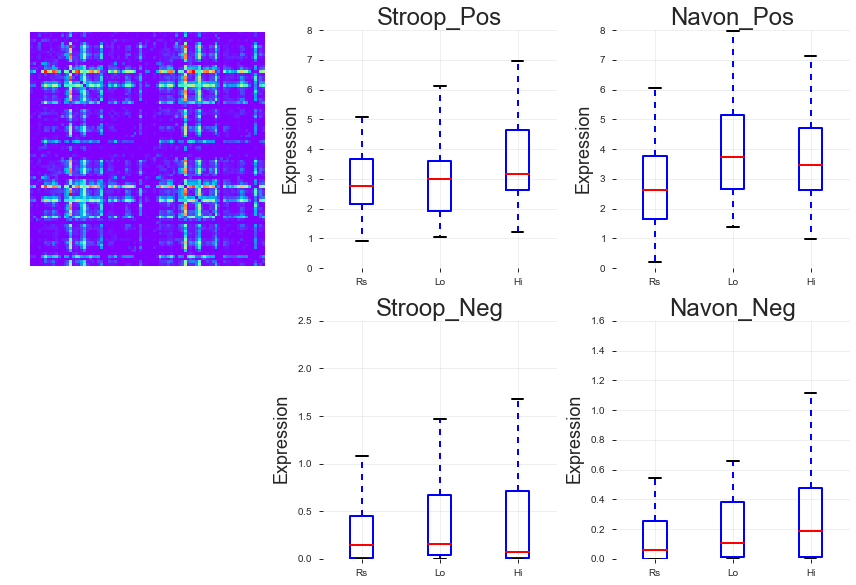





****************************** Subgraph 6 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_posteriorcingulate
    RH_rostralmiddlefrontal
    RH_caudalanteriorcingulate
    LH_caudalanteriorcingulate

      Stroop_Pos: Lo-Rs: ts: 1.464005 pval: 0.077370 sig: 
      Stroop_Pos: Hi-Rs: ts: 4.101548 pval: 0.000169 sig: *
      Stroop_Pos: Hi-Lo: ts: 2.651882 pval: 0.006617 sig: 

       Navon_Pos: Lo-Rs: ts: 0.935147 pval: 0.179001 sig: 
       Navon_Pos: Hi-Rs: ts: 1.363271 pval: 0.092029 sig: 
       Navon_Pos: Hi-Lo: ts: 0.487974 pval: 0.314754 sig: 

      Stroop_Neg: Lo-Rs: ts: nan pval: nan sig: 
      Stroop_Neg: Hi-Rs: ts: nan pval: nan sig: 
      Stroop_Neg: Hi-Lo: ts: nan pval: nan sig: 

       Navon_Neg: Lo-Rs: ts: nan pval: nan sig: 
       Navon_Neg: Hi-Rs: ts: nan pval: nan sig: 
       Navon_Neg: Hi-Lo: ts: nan pval: nan sig: 



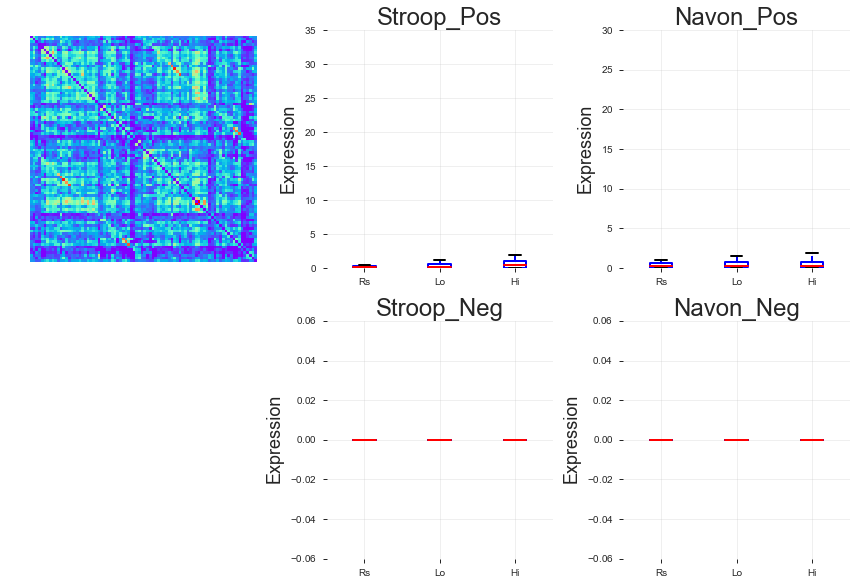





****************************** Subgraph 10 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_cuneus
    LH_lingual
    RH_pericalcarine
    RH_lingual

      Stroop_Pos: Lo-Rs: ts: 2.925399 pval: 0.003447 sig: 
      Stroop_Pos: Hi-Rs: ts: 3.439601 pval: 0.000954 sig: *
      Stroop_Pos: Hi-Lo: ts: 0.784731 pval: 0.219721 sig: 

       Navon_Pos: Lo-Rs: ts: 4.568104 pval: 0.000049 sig: *
       Navon_Pos: Hi-Rs: ts: 6.074673 pval: 0.000001 sig: *
       Navon_Pos: Hi-Lo: ts: 1.931039 pval: 0.032020 sig: 

      Stroop_Neg: Lo-Rs: ts: 0.154628 pval: 0.439132 sig: 
      Stroop_Neg: Hi-Rs: ts: -1.263704 pval: 0.108569 sig: 
      Stroop_Neg: Hi-Lo: ts: -1.399896 pval: 0.086465 sig: 

       Navon_Neg: Lo-Rs: ts: -0.328991 pval: 0.372350 sig: 
       Navon_Neg: Hi-Rs: ts: -0.065427 pval: 0.474158 sig: 
       Navon_Neg: Hi-Lo: ts: 0.550913 pval: 0.293112 sig: 



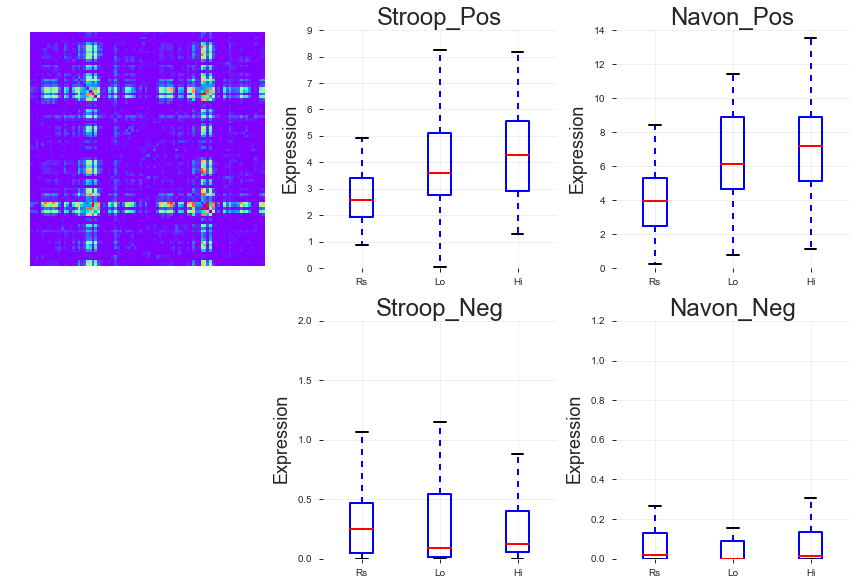





****************************** Subgraph 16 ******************************
    RH_caudalmiddlefrontal
    RH_inferiorparietal
    RH_rostralmiddlefrontal
    RH_parsorbitalis
    LH_lateraloccipital
    RH_middletemporal

      Stroop_Pos: Lo-Rs: ts: 0.749084 pval: 0.230142 sig: 
      Stroop_Pos: Hi-Rs: ts: 4.445676 pval: 0.000067 sig: *
      Stroop_Pos: Hi-Lo: ts: 4.732848 pval: 0.000031 sig: *

       Navon_Pos: Lo-Rs: ts: 4.146862 pval: 0.000150 sig: *
       Navon_Pos: Hi-Rs: ts: 4.038709 pval: 0.000200 sig: *
       Navon_Pos: Hi-Lo: ts: 0.201837 pval: 0.420779 sig: 

      Stroop_Neg: Lo-Rs: ts: 0.840778 pval: 0.203928 sig: 
      Stroop_Neg: Hi-Rs: ts: -1.788369 pval: 0.042472 sig: 
      Stroop_Neg: Hi-Lo: ts: -2.077543 pval: 0.023695 sig: 

       Navon_Neg: Lo-Rs: ts: -1.233083 pval: 0.114087 sig: 
       Navon_Neg: Hi-Rs: ts: -0.981181 pval: 0.167607 sig: 
       Navon_Neg: Hi-Lo: ts: 0.000498 pval: 0.499803 sig: 



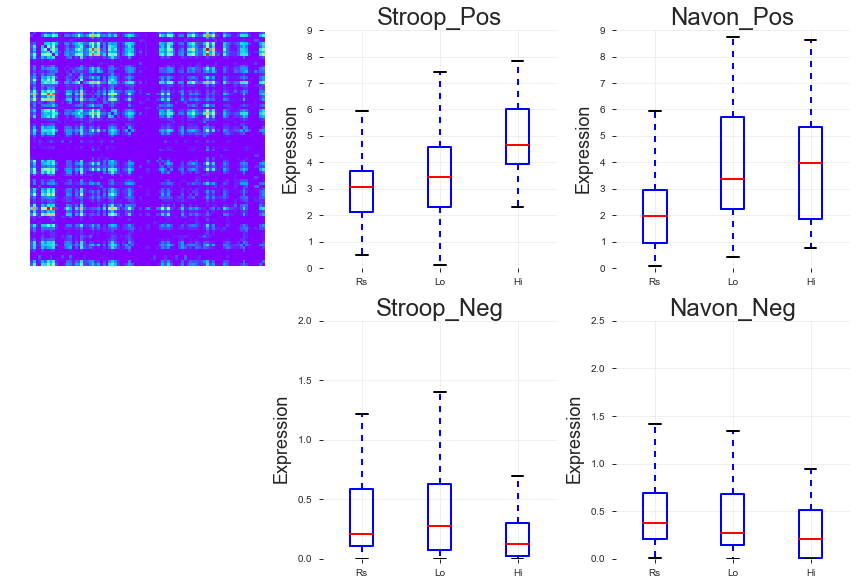





****************************** Subgraph 17 ******************************
    RH_postcentral
    LH_medialorbitofrontal
    LH_paracentral
    LH_rostralanteriorcingulate
    LH_postcentral
    RH_paracentral

      Stroop_Pos: Lo-Rs: ts: 2.187798 pval: 0.018759 sig: 
      Stroop_Pos: Hi-Rs: ts: 3.833464 pval: 0.000343 sig: *
      Stroop_Pos: Hi-Lo: ts: 2.150281 pval: 0.020324 sig: 

       Navon_Pos: Lo-Rs: ts: 3.383579 pval: 0.001100 sig: *
       Navon_Pos: Hi-Rs: ts: 4.507551 pval: 0.000057 sig: *
       Navon_Pos: Hi-Lo: ts: 1.957856 pval: 0.030328 sig: 

      Stroop_Neg: Lo-Rs: ts: -0.131686 pval: 0.448104 sig: 
      Stroop_Neg: Hi-Rs: ts: -0.801942 pval: 0.214794 sig: 
      Stroop_Neg: Hi-Lo: ts: -0.963085 pval: 0.172026 sig: 

       Navon_Neg: Lo-Rs: ts: -0.312781 pval: 0.378425 sig: 
       Navon_Neg: Hi-Rs: ts: -0.941387 pval: 0.177427 sig: 
       Navon_Neg: Hi-Lo: ts: -0.860433 pval: 0.198563 sig: 



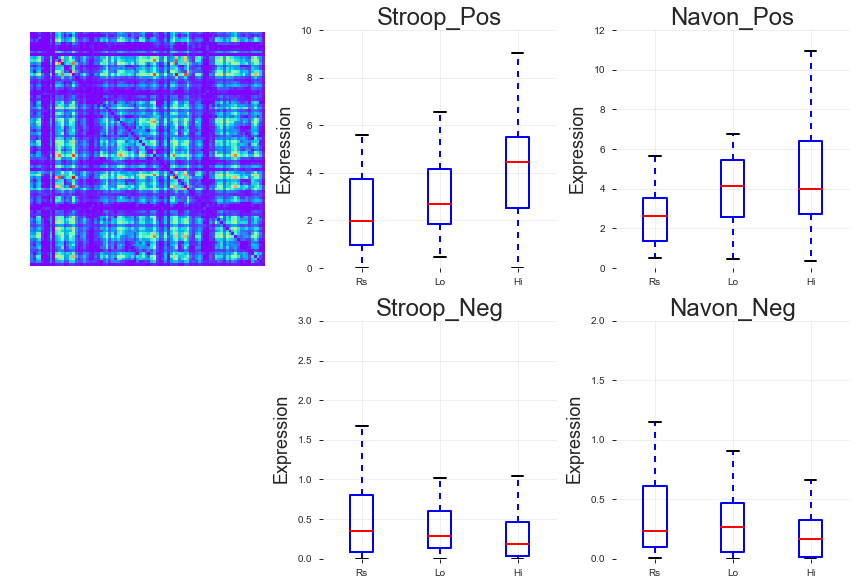





****************************** Subgraph 18 ******************************
    LH_brainstem
    LH_parahippocampal
    RH_parahippocampal
    LH_rostralanteriorcingulate
    LH_thalamusproper
    RH_rostralanteriorcingulate

      Stroop_Pos: Lo-Rs: ts: 0.059916 pval: 0.476332 sig: 
      Stroop_Pos: Hi-Rs: ts: 0.177879 pval: 0.430073 sig: 
      Stroop_Pos: Hi-Lo: ts: 0.103410 pval: 0.459201 sig: 

       Navon_Pos: Lo-Rs: ts: 3.977027 pval: 0.000235 sig: *
       Navon_Pos: Hi-Rs: ts: 1.099110 pval: 0.140712 sig: 
       Navon_Pos: Hi-Lo: ts: -2.212685 pval: 0.017781 sig: 

      Stroop_Neg: Lo-Rs: ts: 0.471700 pval: 0.320465 sig: 
      Stroop_Neg: Hi-Rs: ts: 0.806577 pval: 0.213479 sig: 
      Stroop_Neg: Hi-Lo: ts: 0.006123 pval: 0.497580 sig: 

       Navon_Neg: Lo-Rs: ts: -2.481924 pval: 0.009792 sig: 
       Navon_Neg: Hi-Rs: ts: -1.868911 pval: 0.036260 sig: 
       Navon_Neg: Hi-Lo: ts: 0.233534 pval: 0.408554 sig: 



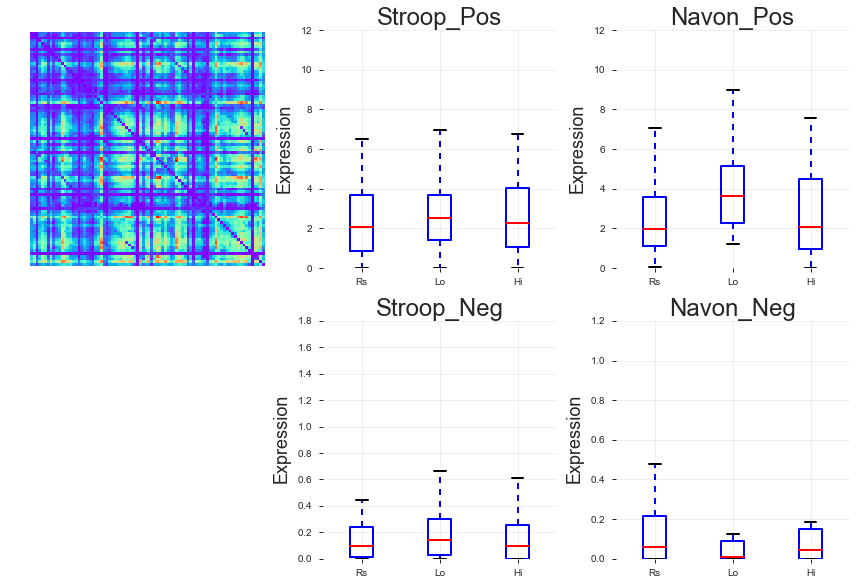





****************************** Subgraph 19 ******************************
    RH_caudalanteriorcingulate
    RH_posteriorcingulate
    LH_posteriorcingulate
    RH_insula
    LH_frontalpole
    RH_isthmuscingulate

      Stroop_Pos: Lo-Rs: ts: 2.379517 pval: 0.012331 sig: 
      Stroop_Pos: Hi-Rs: ts: 1.067541 pval: 0.147590 sig: 
      Stroop_Pos: Hi-Lo: ts: -1.623347 pval: 0.058067 sig: 

       Navon_Pos: Lo-Rs: ts: 3.870943 pval: 0.000311 sig: *
       Navon_Pos: Hi-Rs: ts: 2.849966 pval: 0.004136 sig: 
       Navon_Pos: Hi-Lo: ts: -1.515531 pval: 0.070629 sig: 

      Stroop_Neg: Lo-Rs: ts: -1.847239 pval: 0.037849 sig: 
      Stroop_Neg: Hi-Rs: ts: -1.226862 pval: 0.115233 sig: 
      Stroop_Neg: Hi-Lo: ts: 0.694848 pval: 0.246544 sig: 

       Navon_Neg: Lo-Rs: ts: 1.005390 pval: 0.161817 sig: 
       Navon_Neg: Hi-Rs: ts: -1.301208 pval: 0.102091 sig: 
       Navon_Neg: Hi-Lo: ts: -1.306259 pval: 0.101242 sig: 



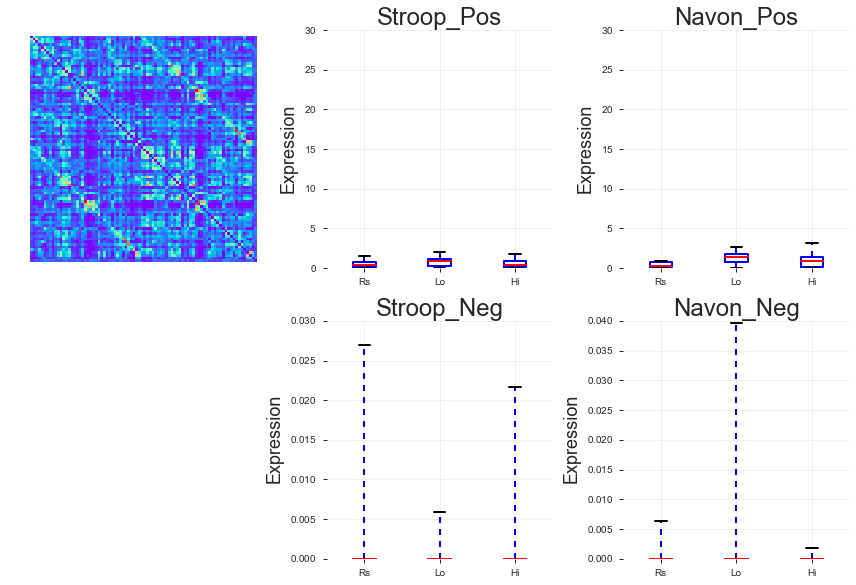





****************************** Subgraph 21 ******************************
    LH_lateraloccipital
    LH_fusiform
    RH_lateraloccipital
    RH_fusiform
    LH_precentral
    LH_superiorparietal

      Stroop_Pos: Lo-Rs: ts: 1.391536 pval: 0.087711 sig: 
      Stroop_Pos: Hi-Rs: ts: 3.410963 pval: 0.001026 sig: *
      Stroop_Pos: Hi-Lo: ts: 2.547077 pval: 0.008437 sig: 

       Navon_Pos: Lo-Rs: ts: 4.961266 pval: 0.000017 sig: *
       Navon_Pos: Hi-Rs: ts: 8.449160 pval: 0.000000 sig: *
       Navon_Pos: Hi-Lo: ts: 3.532948 pval: 0.000750 sig: *

      Stroop_Neg: Lo-Rs: ts: -0.906311 pval: 0.186394 sig: 
      Stroop_Neg: Hi-Rs: ts: -1.475152 pval: 0.075869 sig: 
      Stroop_Neg: Hi-Lo: ts: -0.903731 pval: 0.187065 sig: 

       Navon_Neg: Lo-Rs: ts: -1.475472 pval: 0.075827 sig: 
       Navon_Neg: Hi-Rs: ts: -2.893746 pval: 0.003721 sig: 
       Navon_Neg: Hi-Lo: ts: -1.416386 pval: 0.084048 sig: 



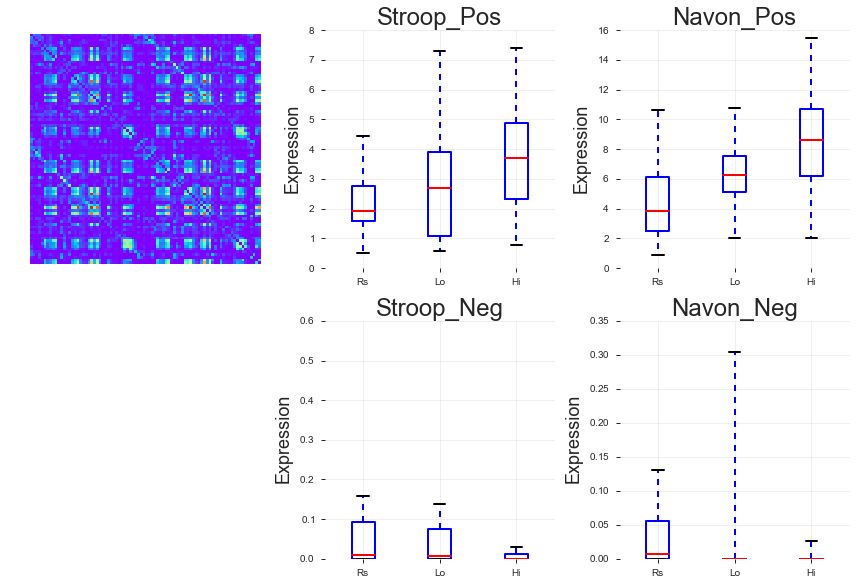





****************************** Subgraph 23 ******************************
    LH_paracentral
    RH_paracentral
    RH_posteriorcingulate
    LH_posteriorcingulate
    LH_caudalanteriorcingulate
    LH_precentral

      Stroop_Pos: Lo-Rs: ts: 1.100246 pval: 0.140469 sig: 
      Stroop_Pos: Hi-Rs: ts: 2.692924 pval: 0.006010 sig: 
      Stroop_Pos: Hi-Lo: ts: 2.012924 pval: 0.027096 sig: 

       Navon_Pos: Lo-Rs: ts: 4.963230 pval: 0.000017 sig: *
       Navon_Pos: Hi-Rs: ts: 2.958763 pval: 0.003178 sig: 
       Navon_Pos: Hi-Lo: ts: -1.288011 pval: 0.104336 sig: 

      Stroop_Neg: Lo-Rs: ts: 1.578917 pval: 0.063000 sig: 
      Stroop_Neg: Hi-Rs: ts: 0.968226 pval: 0.170763 sig: 
      Stroop_Neg: Hi-Lo: ts: -0.291625 pval: 0.386401 sig: 

       Navon_Neg: Lo-Rs: ts: 0.659313 pval: 0.257640 sig: 
       Navon_Neg: Hi-Rs: ts: 1.442185 pval: 0.080375 sig: 
       Navon_Neg: Hi-Lo: ts: 1.475823 pval: 0.075780 sig: 



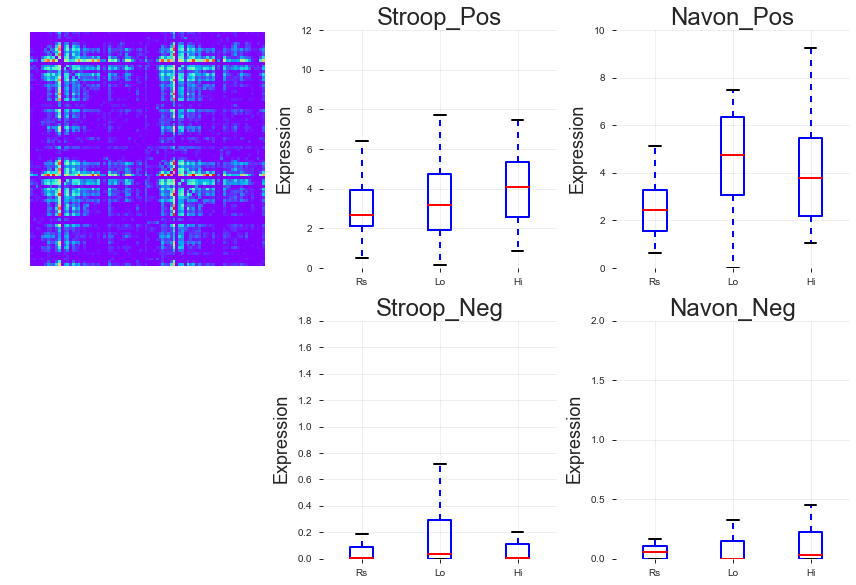





****************************** Subgraph 33 ******************************
    LH_putamen
    RH_putamen
    LH_parsopercularis
    LH_caudate
    RH_parsopercularis
    RH_caudate

      Stroop_Pos: Lo-Rs: ts: -1.763545 pval: 0.044562 sig: 
      Stroop_Pos: Hi-Rs: ts: -1.589580 pval: 0.061786 sig: 
      Stroop_Pos: Hi-Lo: ts: -1.226902 pval: 0.115225 sig: 

       Navon_Pos: Lo-Rs: ts: -2.772368 pval: 0.004980 sig: 
       Navon_Pos: Hi-Rs: ts: -1.221871 pval: 0.116159 sig: 
       Navon_Pos: Hi-Lo: ts: 3.581396 pval: 0.000662 sig: *

      Stroop_Neg: Lo-Rs: ts: -1.454355 pval: 0.078688 sig: 
      Stroop_Neg: Hi-Rs: ts: -1.454355 pval: 0.078688 sig: 
      Stroop_Neg: Hi-Lo: ts: nan pval: nan sig: 

       Navon_Neg: Lo-Rs: ts: 1.000000 pval: 0.163094 sig: 
       Navon_Neg: Hi-Rs: ts: nan pval: nan sig: 
       Navon_Neg: Hi-Lo: ts: -1.000000 pval: 0.163094 sig: 



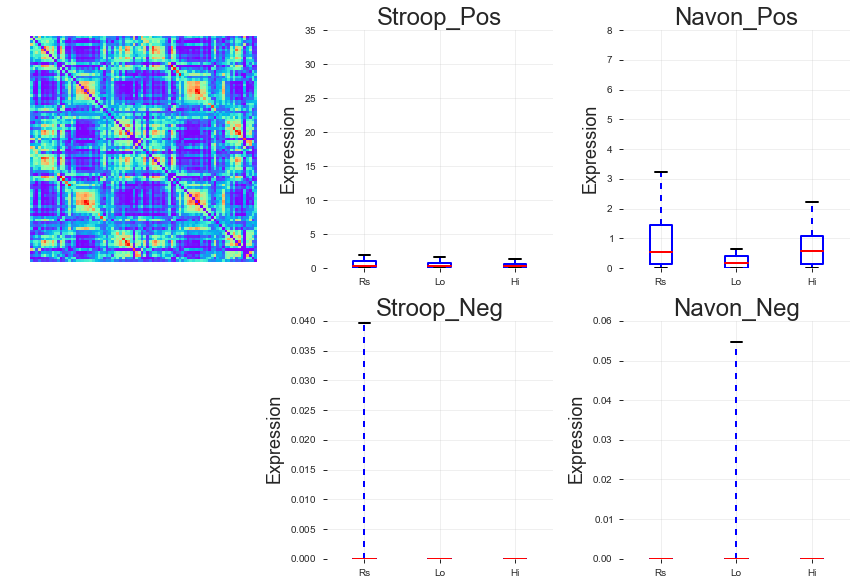





****************************** Subgraph 34 ******************************
    LH_rostralanteriorcingulate
    RH_rostralanteriorcingulate
    LH_frontalpole
    LH_medialorbitofrontal
    LH_lateraloccipital
    RH_lateraloccipital

      Stroop_Pos: Lo-Rs: ts: -1.309509 pval: 0.100698 sig: 
      Stroop_Pos: Hi-Rs: ts: -0.559642 pval: 0.290169 sig: 
      Stroop_Pos: Hi-Lo: ts: 0.898913 pval: 0.188323 sig: 

       Navon_Pos: Lo-Rs: ts: 0.838971 pval: 0.204426 sig: 
       Navon_Pos: Hi-Rs: ts: -0.142815 pval: 0.443748 sig: 
       Navon_Pos: Hi-Lo: ts: -0.967472 pval: 0.170948 sig: 

      Stroop_Neg: Lo-Rs: ts: 2.509622 pval: 0.009193 sig: 
      Stroop_Neg: Hi-Rs: ts: 3.281436 pval: 0.001426 sig: *
      Stroop_Neg: Hi-Lo: ts: -0.046316 pval: 0.481700 sig: 

       Navon_Neg: Lo-Rs: ts: 2.349316 pval: 0.013188 sig: 
       Navon_Neg: Hi-Rs: ts: 3.315997 pval: 0.001306 sig: *
       Navon_Neg: Hi-Lo: ts: 1.221631 pval: 0.116203 sig: 



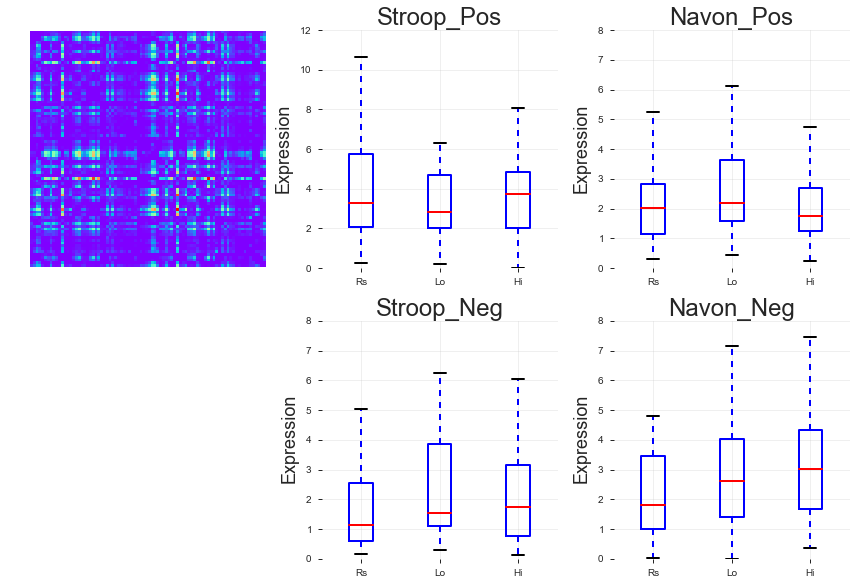





****************************** Subgraph 36 ******************************
    LH_parsorbitalis
    RH_parsorbitalis
    LH_parstriangularis
    LH_middletemporal
    LH_rostralanteriorcingulate
    RH_middletemporal

      Stroop_Pos: Lo-Rs: ts: 1.679498 pval: 0.052296 sig: 
      Stroop_Pos: Hi-Rs: ts: 0.096804 pval: 0.461799 sig: 
      Stroop_Pos: Hi-Lo: ts: -1.823455 pval: 0.039662 sig: 

       Navon_Pos: Lo-Rs: ts: 2.846144 pval: 0.004174 sig: 
       Navon_Pos: Hi-Rs: ts: 3.196717 pval: 0.001764 sig: *
       Navon_Pos: Hi-Lo: ts: 1.393356 pval: 0.087439 sig: 

      Stroop_Neg: Lo-Rs: ts: -0.937913 pval: 0.178302 sig: 
      Stroop_Neg: Hi-Rs: ts: -0.302188 pval: 0.382412 sig: 
      Stroop_Neg: Hi-Lo: ts: 0.888898 pval: 0.190955 sig: 

       Navon_Neg: Lo-Rs: ts: 0.020474 pval: 0.491908 sig: 
       Navon_Neg: Hi-Rs: ts: -0.250172 pval: 0.402174 sig: 
       Navon_Neg: Hi-Lo: ts: -0.237571 pval: 0.407004 sig: 



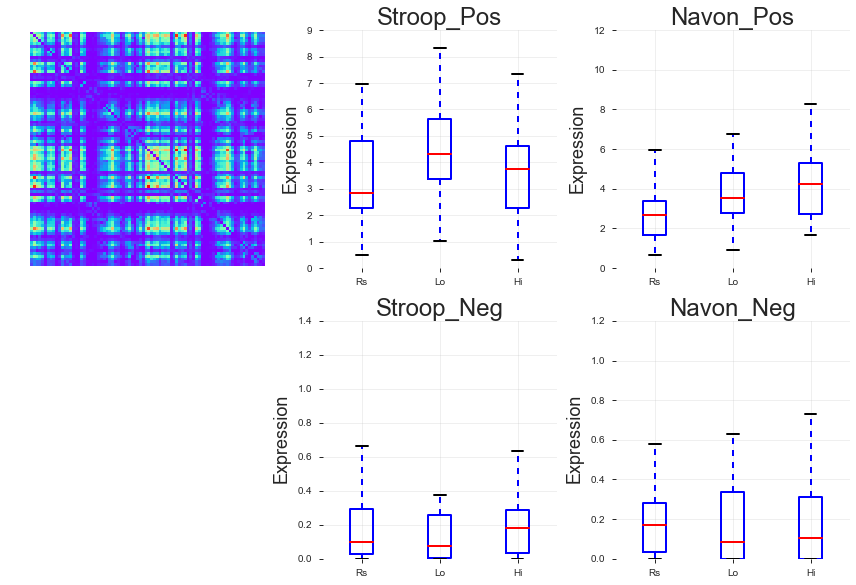





****************************** Subgraph 48 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_pericalcarine
    RH_cuneus
    LH_lingual
    RH_lingual

      Stroop_Pos: Lo-Rs: ts: 3.194301 pval: 0.001775 sig: *
      Stroop_Pos: Hi-Rs: ts: 3.145084 pval: 0.002007 sig: *
      Stroop_Pos: Hi-Lo: ts: -0.845577 pval: 0.202610 sig: 

       Navon_Pos: Lo-Rs: ts: -0.409856 pval: 0.342573 sig: 
       Navon_Pos: Hi-Rs: ts: -2.729439 pval: 0.005514 sig: 
       Navon_Pos: Hi-Lo: ts: -1.925302 pval: 0.032393 sig: 

      Stroop_Neg: Lo-Rs: ts: -0.993537 pval: 0.164635 sig: 
      Stroop_Neg: Hi-Rs: ts: -0.560370 pval: 0.289924 sig: 
      Stroop_Neg: Hi-Lo: ts: 0.346008 pval: 0.366009 sig: 

       Navon_Neg: Lo-Rs: ts: 0.648244 pval: 0.261151 sig: 
       Navon_Neg: Hi-Rs: ts: 3.277994 pval: 0.001438 sig: *
       Navon_Neg: Hi-Lo: ts: 1.668597 pval: 0.053377 sig: 



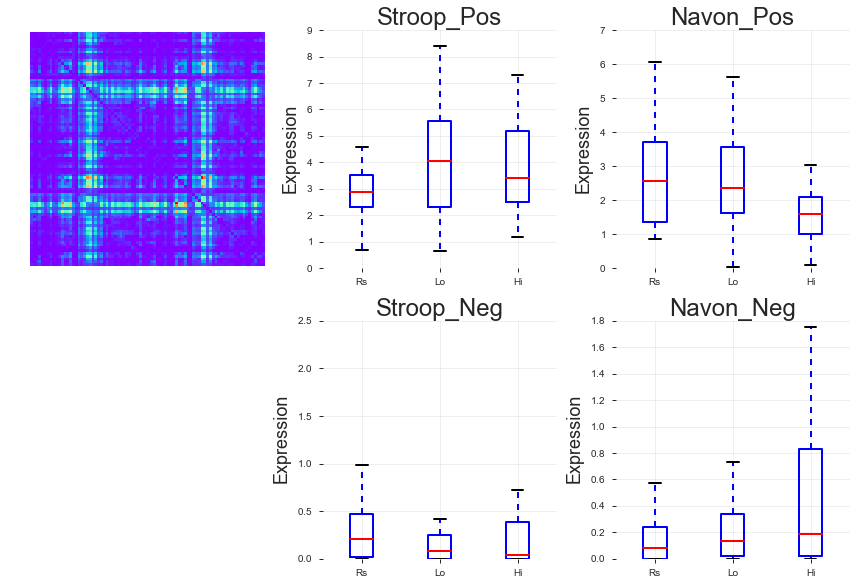

In [51]:
%matplotlib inline

path_cfg_expr = glob.glob('{}/NMF_Optimization.CfgMatr.npz'.format(path_InpData))[0]
df_cfg = np.load(path_cfg_expr, mmap_mode='r')
cfg_key = df_cfg['cfg_key']
key_grp = {'Stroop_Pos': {'Rs': ['adj_rs_pos_Stroop'],
                          'Lo': ['adj_lo_pos_Stroop'],
                          'Hi': ['adj_hi_pos_Stroop']},
           'Navon_Pos' : {'Rs': ['adj_rs_pos_Navon'],
                          'Lo': ['adj_lo_pos_Navon'],
                          'Hi': ['adj_hi_pos_Navon']},
           'Stroop_Neg': {'Rs': ['adj_rs_neg_Stroop'],
                          'Lo': ['adj_lo_neg_Stroop'],
                          'Hi': ['adj_hi_neg_Stroop']},
           'Navon_Neg' : {'Rs': ['adj_rs_neg_Navon'],
                          'Lo': ['adj_lo_neg_Navon'],
                          'Hi': ['adj_hi_neg_Navon']}}
grp_order = ['Stroop_Pos', 'Navon_Pos', 'Stroop_Neg', 'Navon_Neg']
key_order = ['Rs', 'Lo', 'Hi']

sel_fac_ix = np.arange(n_fac)

# Populate plot database
plot_list = []
for fac_ii in sel_fac_ix:
    plot_dict = {'subgraph': conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]),
                 'subplot': []}
                 
    for grp in grp_order: #key_grp.keys():
        subplot_dict = {'title': grp,
                        'xlabel': [],
                        'distrib': [],
                        'stats': []}
        
        for key in key_order: #key_grp[grp].keys():
            key_ix = np.flatnonzero(cfg_key == key_grp[grp][key][0])
            
            subj_coef = fac_coef[fac_ii, key_ix].reshape(-1, 6)

            mean_subj_coef = np.mean(subj_coef, axis=1)
            
            subplot_dict['xlabel'].append(key)
            subplot_dict['distrib'].append(mean_subj_coef)
            
        for key_pair in [[1,0], [2,0], [2,1]]:
            ts, pv = stats.ttest_rel(subplot_dict['distrib'][key_pair[0]],
                                     subplot_dict['distrib'][key_pair[1]])      
            subplot_dict['stats'].append({'name': '{}-{}'.format(subplot_dict['xlabel'][key_pair[0]],
                                                                 subplot_dict['xlabel'][key_pair[1]]),
                                          'tstat': ts,
                                          'pval': pv/2.0,
                                          'sig': ''})        
        
        plot_dict['subplot'].append(subplot_dict)
    plot_list.append(plot_dict)

# Benjamini-Hochberg Multiple Comparisons
all_pval = np.sort([fac_stat['pval']
                    for fac_plot in plot_list
                    for fac_subp in fac_plot['subplot']
                    for fac_stat in fac_subp['stats']])[::-1]

alpha = 0.05
n_comp = len(all_pval)
for ix, i in enumerate(range(n_comp, 0, -1)):
    adj_alpha = i/n_comp*alpha
    if all_pval[ix] < adj_alpha:
        break
print('%0.10f' % adj_alpha)

# Re-adjust significant indicator and re-order subgraphs
min_fac_pval = []
sel_fac_within_sig = []
for fac_ii, fac_plot in enumerate(plot_list):
    pval_list = []
    for fac_subp in fac_plot['subplot']:
        for fac_stat in fac_subp['stats']:
            if (fac_stat['pval'] < adj_alpha) & (fac_stat['tstat'] > 0):
                fac_stat['sig'] = '*'
                sel_fac_within_sig.append(fac_ii)
            pval_list.append(fac_stat['pval'])
    min_fac_pval.append(np.min(pval_list))
sel_fac_ord = np.argsort(min_fac_pval)
sel_fac_within_sig = np.unique(sel_fac_within_sig)

# Plot each result
for fac_ix in sel_fac_within_sig:
    fac_plot = plot_list[fac_ix]
    
    plt.figure(figsize=(12,12))
    ax = plt.subplot(3, 3, 1)
    ax.matshow(fac_plot['subgraph'], cmap='rainbow')
    ax.set_axis_off()
    ax_list = [2,3,5,6]
    
    print('****************************** Subgraph {} ******************************'.format(fac_ix+1))    
    sort_roi = np.argsort(np.sum(fac_plot['subgraph'], axis=0))[::-1]
    print('    ' + '\n    '.join([all_roi_names[sort_roi[i]] for i in xrange(6)]))
    print('')

    for subp_ii, fac_subp in enumerate(fac_plot['subplot']):
        ax = plt.subplot(3, 3, ax_list[subp_ii])
        ax.boxplot(fac_subp['distrib'])
        ax.set_xticklabels(fac_subp['xlabel'])
        ax.set_ylabel('Expression')
        ax.set_title(fac_subp['title'])
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')


        for fac_stat in fac_subp['stats']:
            print('    %12s: %s: ts: %0.6f pval: %0.6f sig: %s' % 
                  (fac_subp['title'], fac_stat['name'],
                   fac_stat['tstat'], fac_stat['pval'],
                   fac_stat['sig']))
        print('')
            
    plt.show()
    print('\n\n\n')

## Subgraph Expression vs Behavior

### Load Behavioral Data

In [58]:
df_beh = io.loadmat('{}/BehavioralData_CogControlCorrect.mat'.format(path_CoreData))

stroop_lbl = [lbl[0] for lbl in df_beh['StroopLabels'][0]]
navon_lbl = [lbl[0] for lbl in df_beh['NavonLabels'][0]]
stroop_beh = df_beh['StroopCorrectOnly']
navon_beh = df_beh['NavonCorrectOnly']

# Removed subjects
bad_subj_ix = [1, 6]
good_subj_ix = np.setdiff1d(np.arange(stroop_beh.shape[0]), bad_subj_ix)

# Excessive movement
stroop_move = io.loadmat('{}/StroopMove.mat'.format(path_CoreData))['move'][:, 0]
navon_move = io.loadmat('{}/NavonMove.mat'.format(path_CoreData))['move'][:, 0]

# Reaction Time
stroop_interf_rt = stroop_beh[good_subj_ix, 5]
navon_interf_rt = navon_beh[good_subj_ix, 5]

stroop_noninterf_rt = stroop_beh[good_subj_ix, 7]
navon_noninterf_rt = navon_beh[good_subj_ix, 7]

stroop_cost_rt = stroop_interf_rt - stroop_noninterf_rt
navon_cost_rt = navon_interf_rt - navon_noninterf_rt

# Accuracy
stroop_interf_acc = stroop_beh[good_subj_ix, 1]
navon_interf_acc = navon_beh[good_subj_ix, 1]

stroop_noninterf_acc = stroop_beh[good_subj_ix, 2]
navon_noninterf_acc = navon_beh[good_subj_ix, 2]

stroop_cost_acc = stroop_noninterf_acc - stroop_interf_acc
navon_cost_acc = navon_noninterf_acc - navon_interf_acc

print('Stroop Labels: {}'.format(stroop_lbl))
print('Navon Labels: {}'.format(navon_lbl))

Stroop Labels: [u'Total Accuracy', u'Interference Accuracy', u'NoInterference Accuracy', u'MeanRT', u'MedianRT', u'InterferenceMeanRT', u'InterferenceMedianRT', u'NoInterferenceMeanRT', u'NoInterferenceMedianRT', u'InterferenceMedianRTMinusMeanRT']
Navon Labels: [u'Total Accuracy', u'ShiftingAccuracy', u'NoShiftingAccuracy', u'MeanRT', u'MedianRT', u'ShiftingMeanRT', u'ShiftingMedianRT', u'NoShiftingMeanRT', u'NoShiftingMedianRT', u'ProportionTotalNonResponses']


### Predicting Interference RT (Hi)

0.0009615385
****************************** Subgraph 4 ******************************
    RH_caudalmiddlefrontal
    RH_inferiorparietal
    RH_rostralmiddlefrontal
    RH_parsorbitalis
    LH_lateraloccipital
    RH_middletemporal

    Stroop: Hi_Pos: rho: -0.51014 pval: 0.00410 sig: 
    Stroop: Hi_Neg: rho: 0.37598 pval: 0.02010 sig: 
    Navon: Hi_Pos: rho: 0.06423 pval: 0.37830 sig: 
    Navon: Hi_Neg: rho: -0.14911 pval: 0.22350 sig: 


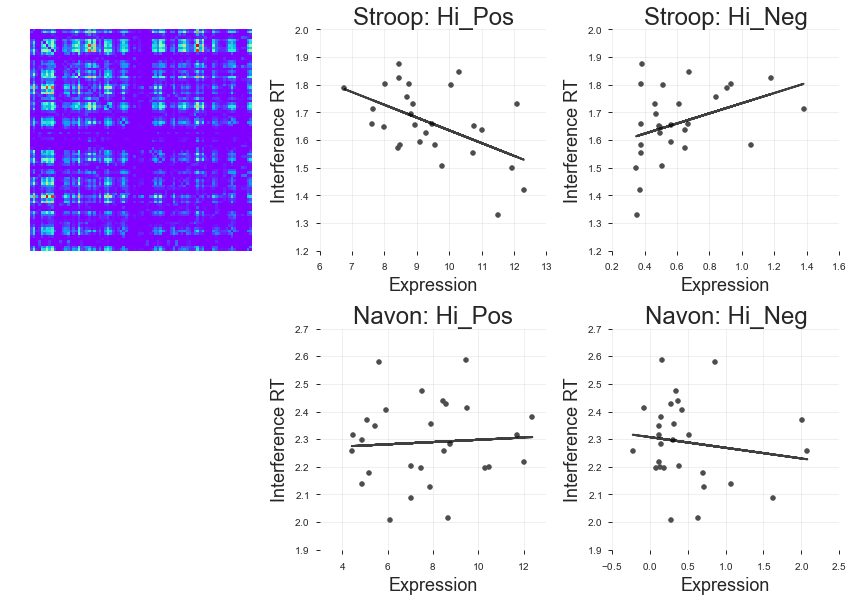





****************************** Subgraph 9 ******************************
    LH_paracentral
    RH_paracentral
    RH_posteriorcingulate
    LH_posteriorcingulate
    LH_caudalanteriorcingulate
    LH_precentral

    Stroop: Hi_Pos: rho: -0.24742 pval: 0.11100 sig: 
    Stroop: Hi_Neg: rho: 0.09779 pval: 0.31370 sig: 
    Navon: Hi_Pos: rho: -0.13388 pval: 0.25470 sig: 
    Navon: Hi_Neg: rho: 0.43791 pval: 0.01140 sig: 


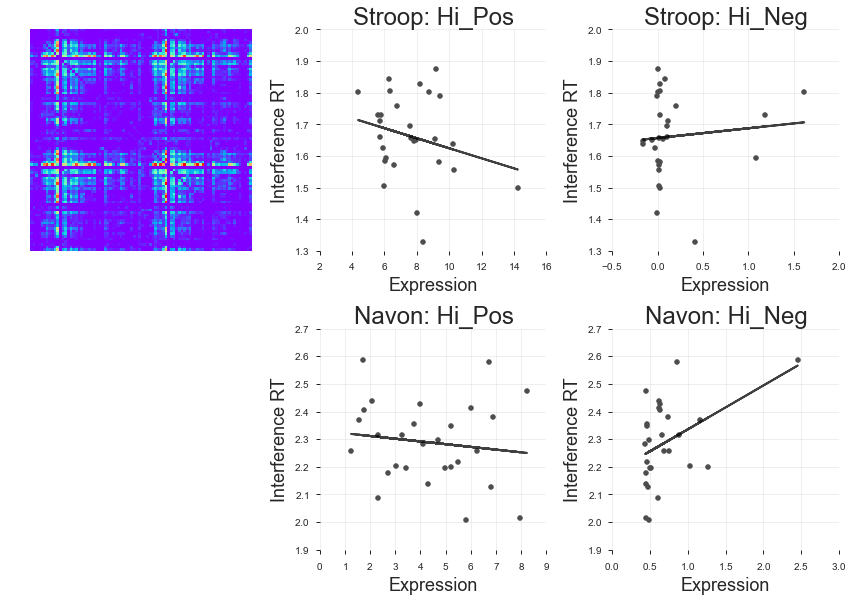





****************************** Subgraph 12 ******************************
    LH_parsorbitalis
    RH_parsorbitalis
    LH_parstriangularis
    LH_middletemporal
    LH_rostralanteriorcingulate
    RH_middletemporal

    Stroop: Hi_Pos: rho: 0.11399 pval: 0.28610 sig: 
    Stroop: Hi_Neg: rho: -0.33528 pval: 0.05140 sig: 
    Navon: Hi_Pos: rho: -0.04945 pval: 0.40910 sig: 
    Navon: Hi_Neg: rho: 0.25034 pval: 0.10480 sig: 


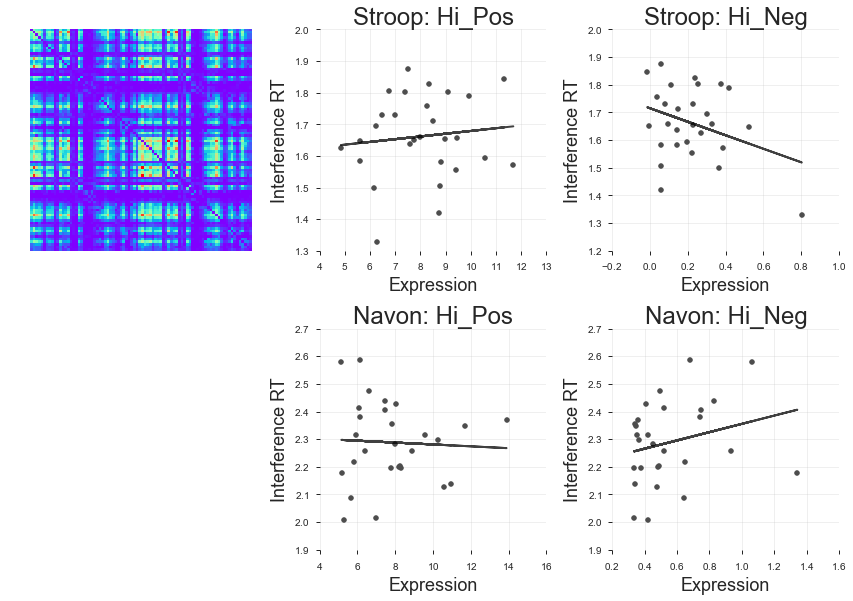





****************************** Subgraph 6 ******************************
    LH_brainstem
    LH_parahippocampal
    RH_parahippocampal
    LH_rostralanteriorcingulate
    LH_thalamusproper
    RH_rostralanteriorcingulate

    Stroop: Hi_Pos: rho: 0.28965 pval: 0.06230 sig: 
    Stroop: Hi_Neg: rho: -0.13336 pval: 0.25180 sig: 
    Navon: Hi_Pos: rho: -0.10928 pval: 0.29940 sig: 
    Navon: Hi_Neg: rho: -0.22763 pval: 0.12780 sig: 


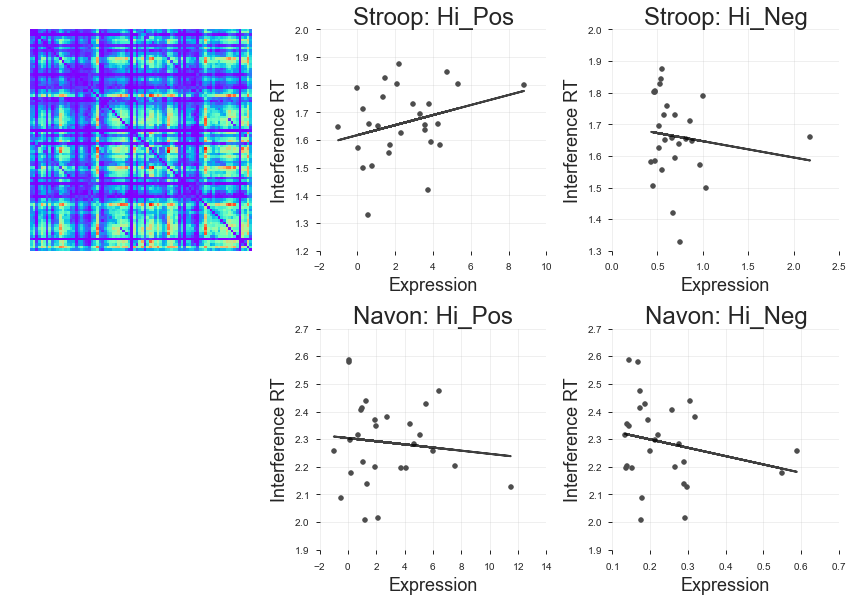





****************************** Subgraph 8 ******************************
    LH_lateraloccipital
    LH_fusiform
    RH_lateraloccipital
    RH_fusiform
    LH_precentral
    LH_superiorparietal

    Stroop: Hi_Pos: rho: -0.21626 pval: 0.13700 sig: 
    Stroop: Hi_Neg: rho: 0.14760 pval: 0.23960 sig: 
    Navon: Hi_Pos: rho: 0.01302 pval: 0.47050 sig: 
    Navon: Hi_Neg: rho: -0.02954 pval: 0.43610 sig: 


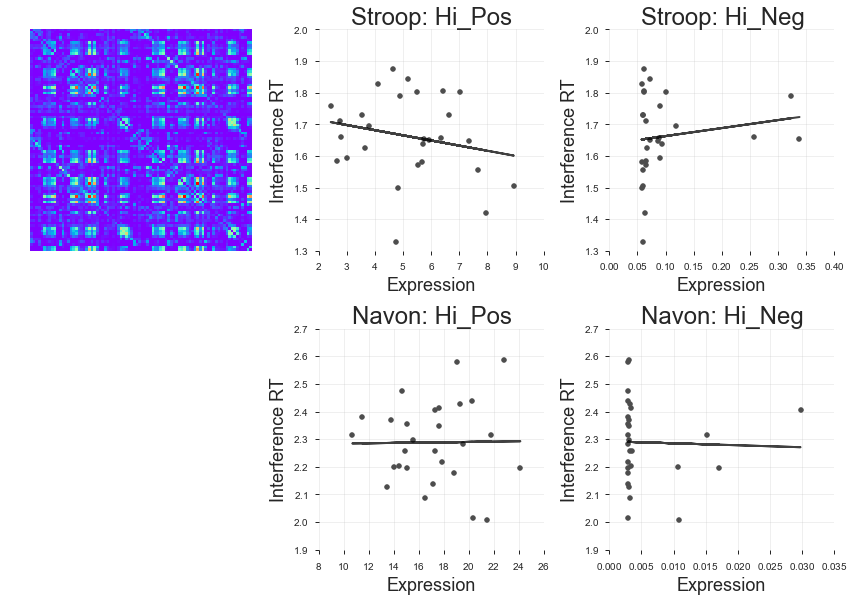





****************************** Subgraph 1 ******************************
    LH_isthmuscingulate
    RH_isthmuscingulate
    LH_precuneus
    RH_precuneus
    LH_parahippocampal
    RH_parahippocampal

    Stroop: Hi_Pos: rho: -0.11453 pval: 0.28210 sig: 
    Stroop: Hi_Neg: rho: 0.19437 pval: 0.16730 sig: 
    Navon: Hi_Pos: rho: -0.04209 pval: 0.43010 sig: 
    Navon: Hi_Neg: rho: 0.19982 pval: 0.15540 sig: 


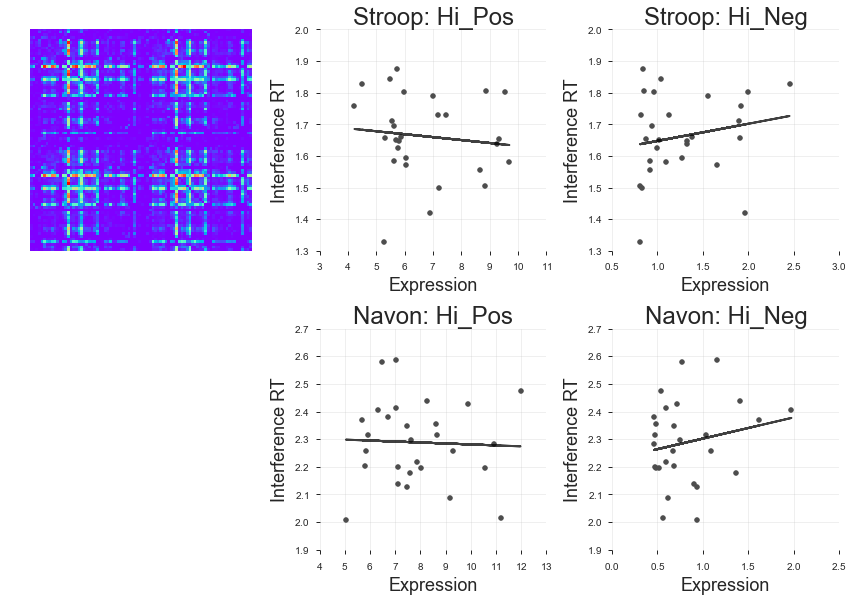





****************************** Subgraph 13 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_pericalcarine
    RH_cuneus
    LH_lingual
    RH_lingual

    Stroop: Hi_Pos: rho: -0.01709 pval: 0.46230 sig: 
    Stroop: Hi_Neg: rho: 0.19376 pval: 0.16080 sig: 
    Navon: Hi_Pos: rho: -0.16679 pval: 0.20290 sig: 
    Navon: Hi_Neg: rho: 0.10866 pval: 0.29330 sig: 


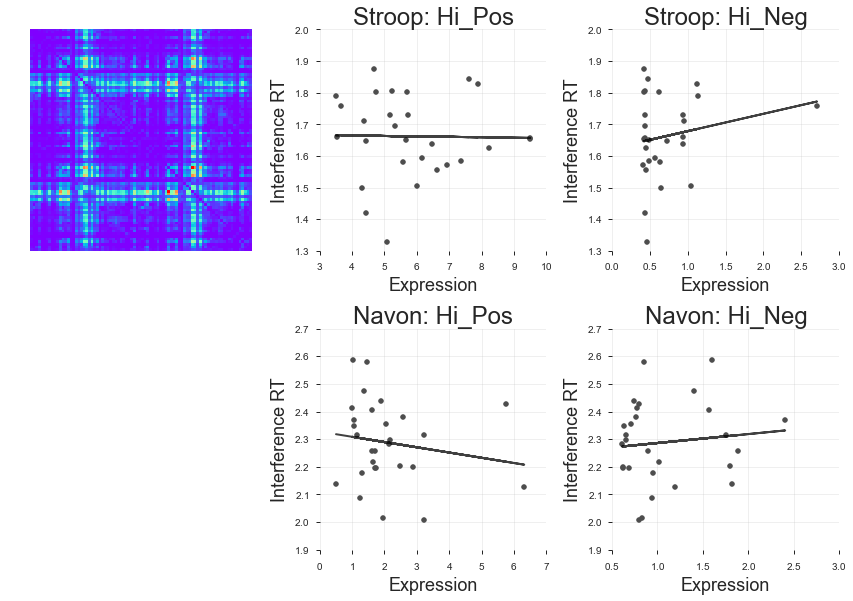





****************************** Subgraph 5 ******************************
    RH_postcentral
    LH_medialorbitofrontal
    LH_paracentral
    LH_rostralanteriorcingulate
    LH_postcentral
    RH_paracentral

    Stroop: Hi_Pos: rho: -0.18610 pval: 0.17120 sig: 
    Stroop: Hi_Neg: rho: 0.02242 pval: 0.47340 sig: 
    Navon: Hi_Pos: rho: 0.14758 pval: 0.22970 sig: 
    Navon: Hi_Neg: rho: -0.09167 pval: 0.32310 sig: 


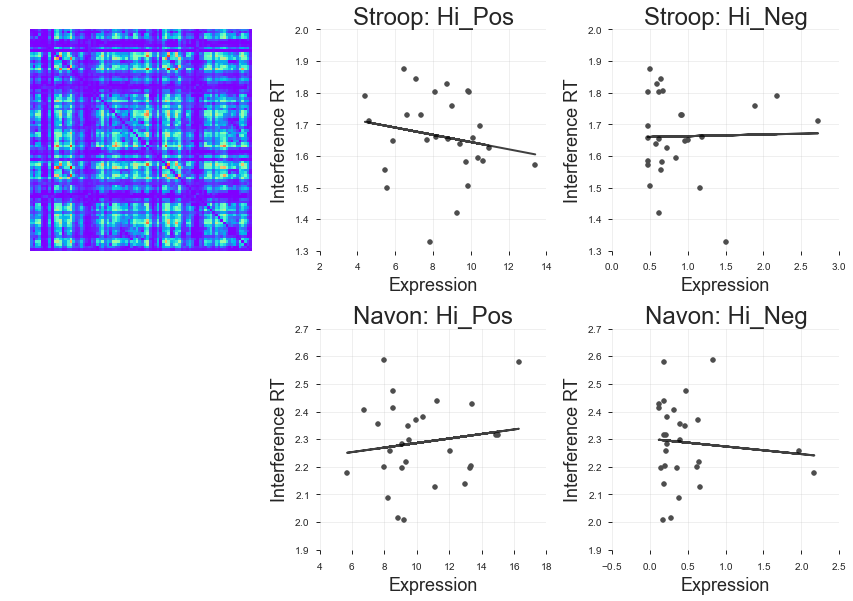





****************************** Subgraph 7 ******************************
    RH_caudalanteriorcingulate
    RH_posteriorcingulate
    LH_posteriorcingulate
    RH_insula
    LH_frontalpole
    RH_isthmuscingulate

    Stroop: Hi_Pos: rho: 0.15136 pval: 0.23110 sig: 
    Stroop: Hi_Neg: rho: -0.12307 pval: 0.26030 sig: 
    Navon: Hi_Pos: rho: 0.09399 pval: 0.32620 sig: 
    Navon: Hi_Neg: rho: 0.18817 pval: 0.17640 sig: 


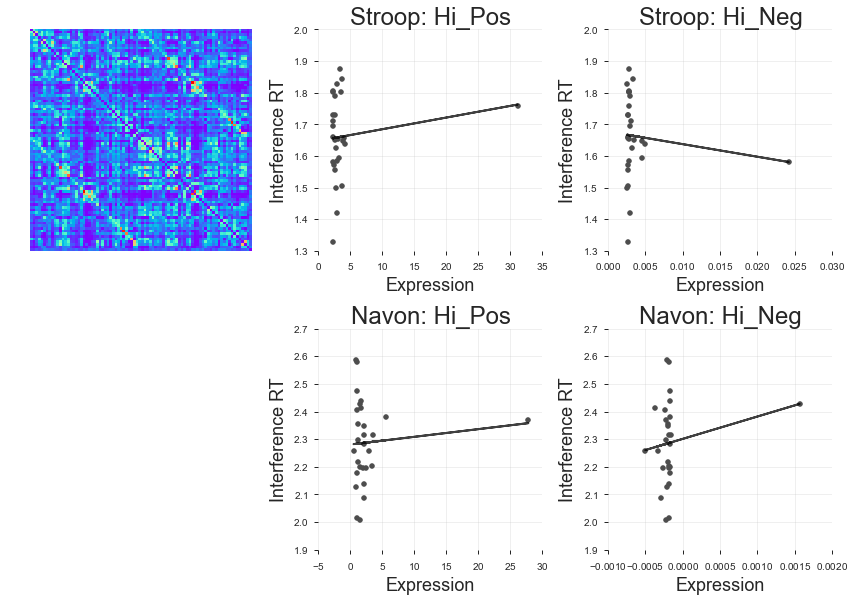





****************************** Subgraph 11 ******************************
    LH_rostralanteriorcingulate
    RH_rostralanteriorcingulate
    LH_frontalpole
    LH_medialorbitofrontal
    LH_lateraloccipital
    RH_lateraloccipital

    Stroop: Hi_Pos: rho: 0.01862 pval: 0.47350 sig: 
    Stroop: Hi_Neg: rho: 0.04035 pval: 0.43210 sig: 
    Navon: Hi_Pos: rho: -0.04297 pval: 0.42020 sig: 
    Navon: Hi_Neg: rho: 0.17062 pval: 0.19630 sig: 


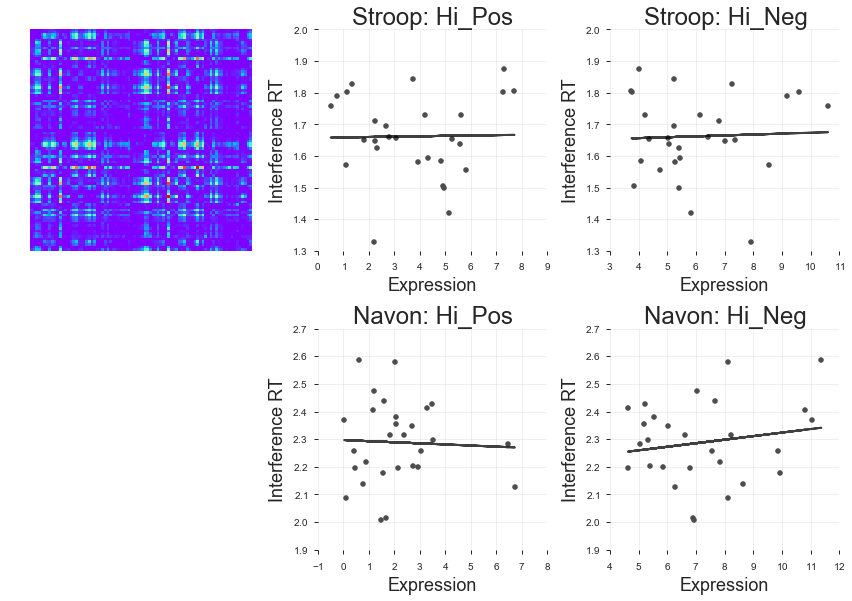





****************************** Subgraph 3 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_cuneus
    LH_lingual
    RH_pericalcarine
    RH_lingual

    Stroop: Hi_Pos: rho: -0.14941 pval: 0.23110 sig: 
    Stroop: Hi_Neg: rho: 0.07535 pval: 0.35970 sig: 
    Navon: Hi_Pos: rho: 0.01599 pval: 0.47400 sig: 
    Navon: Hi_Neg: rho: -0.00222 pval: 0.50540 sig: 


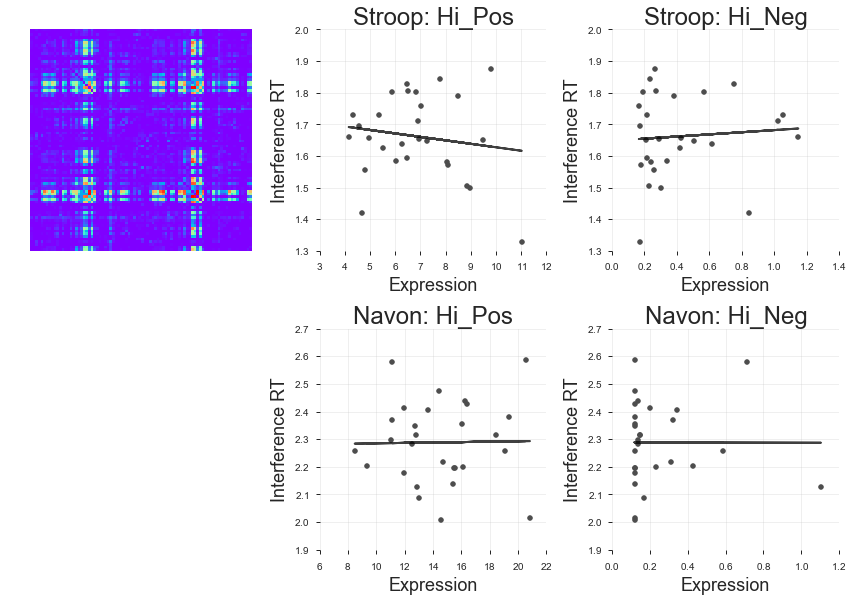





****************************** Subgraph 10 ******************************
    LH_putamen
    RH_putamen
    LH_parsopercularis
    LH_caudate
    RH_parsopercularis
    RH_caudate

    Stroop: Hi_Pos: rho: -0.09722 pval: 0.30150 sig: 
    Stroop: Hi_Neg: rho: 0.00000 pval: 1.00000 sig: 
    Navon: Hi_Pos: rho: 0.04146 pval: 0.41940 sig: 
    Navon: Hi_Neg: rho: 0.00000 pval: 1.00000 sig: 


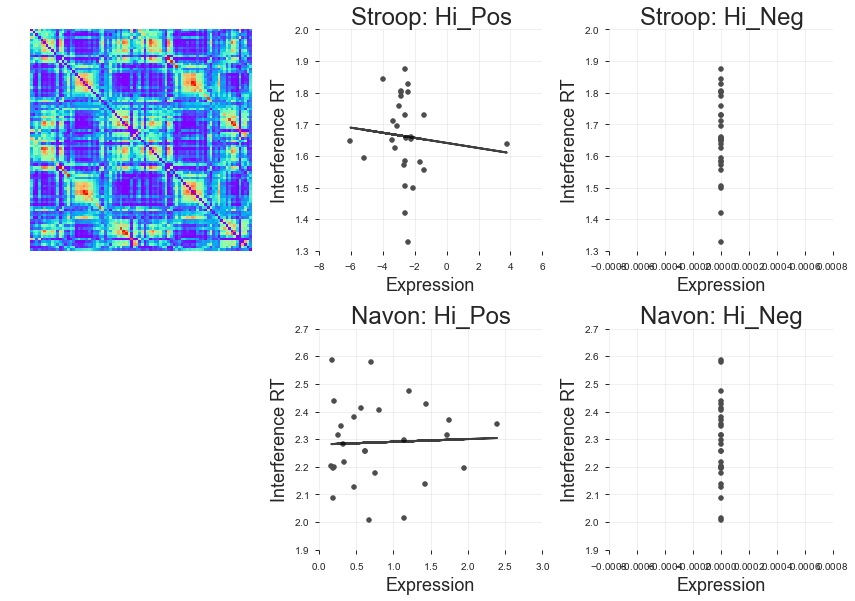





****************************** Subgraph 2 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_posteriorcingulate
    RH_rostralmiddlefrontal
    RH_caudalanteriorcingulate
    LH_caudalanteriorcingulate

    Stroop: Hi_Pos: rho: -0.04253 pval: 0.39520 sig: 
    Stroop: Hi_Neg: rho: 0.00000 pval: 1.00000 sig: 
    Navon: Hi_Pos: rho: -0.00513 pval: 0.49370 sig: 
    Navon: Hi_Neg: rho: 0.00000 pval: 1.00000 sig: 


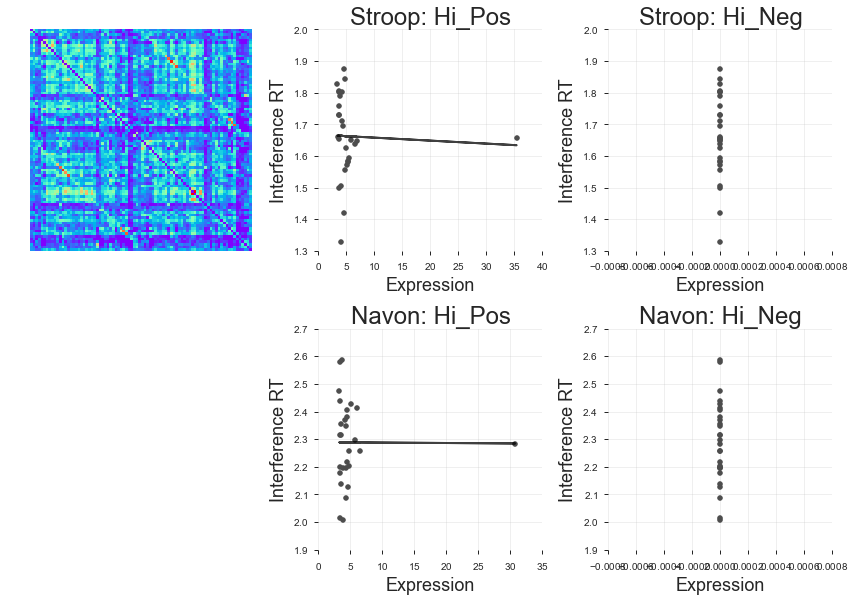

In [56]:
%matplotlib inline

path_cfg_expr = glob.glob('{}/NMF_Optimization.CfgMatr.npz'.format(path_InpData))[0]
df_cfg = np.load(path_cfg_expr, mmap_mode='r')
cfg_key = df_cfg['cfg_key']
key_grp = {'Stroop': {'Hi_Pos': ['adj_hi_pos_Stroop'],
                      'Hi_Neg': ['adj_hi_neg_Stroop']},
           'Navon' : {'Hi_Pos': ['adj_hi_pos_Navon'],
                      'Hi_Neg': ['adj_hi_neg_Navon']}}
grp_order = ['Stroop', 'Navon']
key_order = ['Hi_Pos', 'Hi_Neg']
           
beh_grp = {'Stroop': [stroop_move, stroop_interf_rt],
           'Navon': [navon_move, navon_interf_rt]}

sel_fac_ix = np.arange(n_fac)[sel_fac_within_sig]

# Populate plot database
plot_list = []
for fac_ii in sel_fac_ix:
    plot_dict = {'subgraph': conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]),
                 'subplot': []}
                 
    for grp in grp_order: #key_grp.keys():        
        for key in key_order: #key_grp[grp].keys():
            key_ix = np.flatnonzero(cfg_key == key_grp[grp][key][0])
            
            subj_coef = fac_coef[fac_ii, key_ix].reshape(-1, 6)
            mean_subj_coef = np.mean(subj_coef, axis=1)
            
            m, b, _, _, _ = stats.linregress(beh_grp[grp][0], mean_subj_coef)
            real_mean_subj_coef_nomove = mean_subj_coef - beh_grp[grp][0]*m+b
            
            m, b, _, _, _ = stats.linregress(beh_grp[grp][0], beh_grp[grp][1])
            beh_score_nomove = beh_grp[grp][1] - beh_grp[grp][0]*m+b            
            
            real_m, real_b, real_rho, _, _ = stats.linregress(real_mean_subj_coef_nomove, beh_score_nomove)

            if real_rho == 0:
                pval = 1.0
            else:
                n_count = 0
                n_null = 10000
                for rnd_i in xrange(n_null):
                    null_fac_ix = np.random.randint(0, n_fac)
                    null_key_ix = np.random.randint(0, n_obs, size=len(key_ix))
                    subj_coef = null_fac_coef[null_fac_ix, null_key_ix].reshape(-1, 6)
                    mean_subj_coef = np.mean(subj_coef, axis=1)

                    m, b, _, _, _ = stats.linregress(beh_grp[grp][0], mean_subj_coef)
                    mean_subj_coef_nomove = mean_subj_coef - beh_grp[grp][0]*m+b

                    m, b, rho, _, _ = stats.linregress(mean_subj_coef_nomove, beh_score_nomove)

                    if (real_rho < 0) & (rho < real_rho):
                        n_count += 1

                    if (real_rho > 0) & (rho > real_rho):
                        n_count += 1

                pval = float(n_count) / float(n_null)                    
            
            subplot_dict = {'title': '{}: {}'.format(grp, key),
                            'xlabel': key,
                            'distrib': (real_mean_subj_coef_nomove, beh_score_nomove),
                            'stats': {}}
            subplot_dict['stats'] = {'rho': real_rho,
                                     'pval': pval,
                                     'slope': real_m,
                                     "interc": real_b,
                                     'sig': ''}       
            
            plot_dict['subplot'].append(subplot_dict)
    plot_list.append(plot_dict)


# Benjamini-Hochberg Multiple Comparisons
all_pval = np.sort([fac_subp['stats']['pval']
                    for fac_plot in plot_list
                    for fac_subp in fac_plot['subplot']])[::-1]
alpha = 0.05
n_comp = len(all_pval)
for ix, i in enumerate(range(n_comp, 0, -1)):
    adj_alpha = i/n_comp*alpha
    if all_pval[ix] < adj_alpha:
        break
print('%0.10f' % adj_alpha)

# Re-adjust significant indicator and re-order subgraphs
min_fac_pval = []
for fac_plot in plot_list:
    pval_list = []
    for fac_subp in fac_plot['subplot']:
        if fac_subp['stats']['pval'] < adj_alpha:
            fac_subp['stats']['sig'] = '*'
        pval_list.append(fac_subp['stats']['pval'])
    min_fac_pval.append(np.min(pval_list))
sel_fac_ord = np.argsort(min_fac_pval)

# Plot each result
for fac_ix in sel_fac_ord:
    fac_plot = plot_list[fac_ix]
    
    plt.figure(figsize=(12,12))
    ax = plt.subplot(3, 3, 1)
    ax.matshow(fac_plot['subgraph'], cmap='rainbow')
    ax.set_axis_off()
    ax_list = [2,3,5,6]

    print('****************************** Subgraph {} ******************************'.format(fac_ix+1))    
    sort_roi = np.argsort(np.sum(fac_plot['subgraph'], axis=0))[::-1]
    print('    ' + '\n    '.join([all_roi_names[sort_roi[i]] for i in xrange(6)]))
    print('')

    for subp_ii, fac_subp in enumerate(fac_plot['subplot']):
        ax = plt.subplot(3, 3, ax_list[subp_ii])
        
        ax.plot(fac_subp['distrib'][0], 
                fac_subp['stats']['slope']*fac_subp['distrib'][0]+fac_subp['stats']['interc'],
                color='k', alpha=0.75)
        ax.scatter(fac_subp['distrib'][0], fac_subp['distrib'][1],
                   color=[0.3, 0.3, 0.3])

        ax.set_xlabel('Expression (Hi)')
        ax.set_ylabel('Interference RT')
        ax.set_title(fac_subp['title'])
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')


        print('    %12s: rho: %3.5f pval: %3.5f sig: %s' % 
              (fac_subp['title'],
               fac_subp['stats']['rho'],
               fac_subp['stats']['pval'],
               fac_subp['stats']['sig']))
            
    plt.show()
    print('\n\n\n')

### Predicting Cost RT (Hi-Lo)

0.0009615385
****************************** Subgraph 4 ******************************
    RH_caudalmiddlefrontal
    RH_inferiorparietal
    RH_rostralmiddlefrontal
    RH_parsorbitalis
    LH_lateraloccipital
    RH_middletemporal

     Stroop: Pos: rho: -0.05015 pval: 0.40580 sig: 
     Stroop: Neg: rho: 0.35895 pval: 0.03120 sig: 
      Navon: Pos: rho: 0.45241 pval: 0.00730 sig: 
      Navon: Neg: rho: -0.19798 pval: 0.15520 sig: 


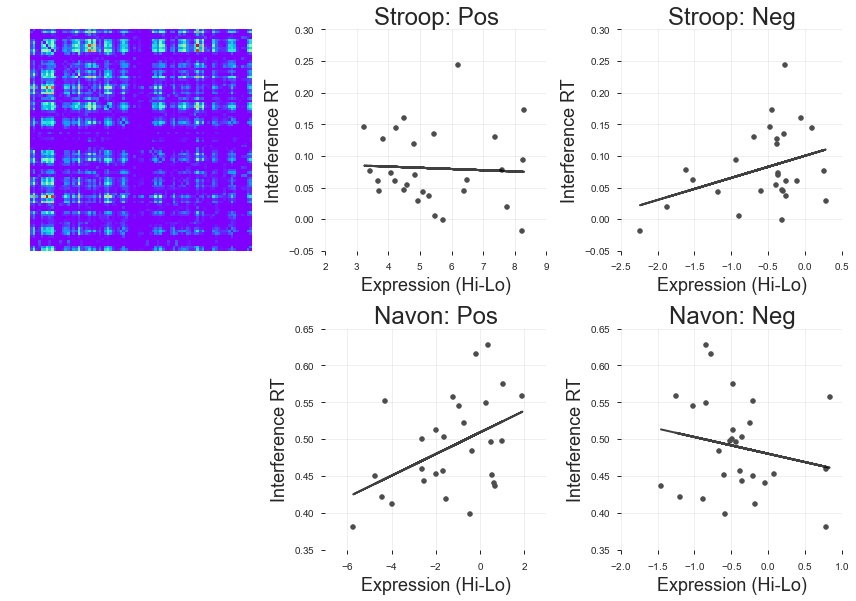





****************************** Subgraph 12 ******************************
    LH_parsorbitalis
    RH_parsorbitalis
    LH_parstriangularis
    LH_middletemporal
    LH_rostralanteriorcingulate
    RH_middletemporal

     Stroop: Pos: rho: -0.02421 pval: 0.46140 sig: 
     Stroop: Neg: rho: -0.47404 pval: 0.00800 sig: 
      Navon: Pos: rho: 0.02352 pval: 0.45590 sig: 
      Navon: Neg: rho: 0.39650 pval: 0.01840 sig: 


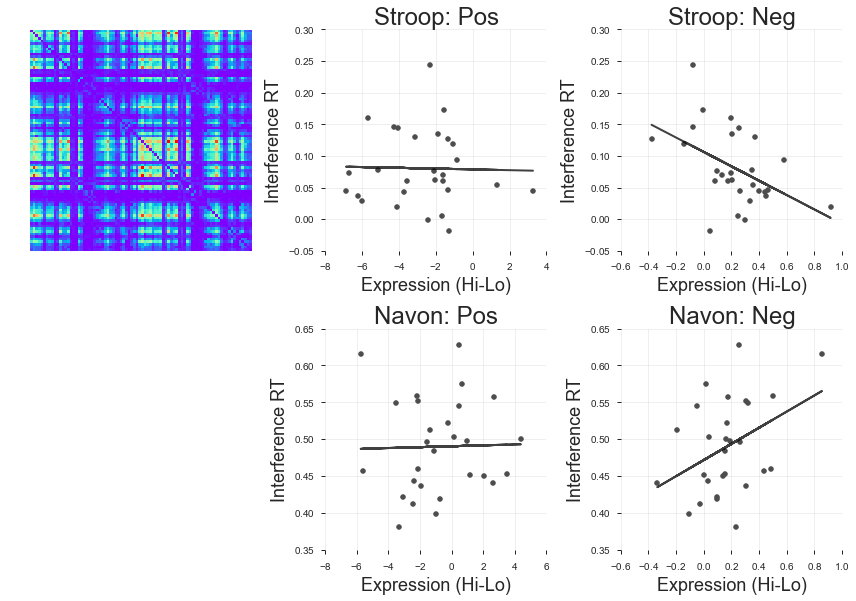





****************************** Subgraph 2 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_posteriorcingulate
    RH_rostralmiddlefrontal
    RH_caudalanteriorcingulate
    LH_caudalanteriorcingulate

     Stroop: Pos: rho: -0.15474 pval: 0.21500 sig: 
     Stroop: Neg: rho: 0.00000 pval: 1.00000 sig: 
      Navon: Pos: rho: -0.38898 pval: 0.02070 sig: 
      Navon: Neg: rho: 0.00000 pval: 1.00000 sig: 


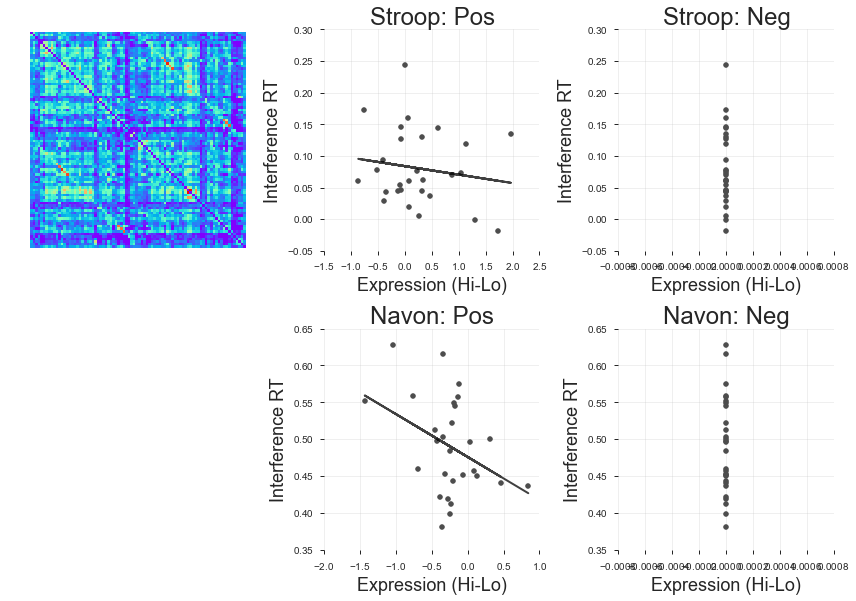





****************************** Subgraph 9 ******************************
    LH_paracentral
    RH_paracentral
    RH_posteriorcingulate
    LH_posteriorcingulate
    LH_caudalanteriorcingulate
    LH_precentral

     Stroop: Pos: rho: -0.19656 pval: 0.16010 sig: 
     Stroop: Neg: rho: -0.00509 pval: 0.48930 sig: 
      Navon: Pos: rho: 0.22370 pval: 0.13740 sig: 
      Navon: Neg: rho: 0.32802 pval: 0.04680 sig: 


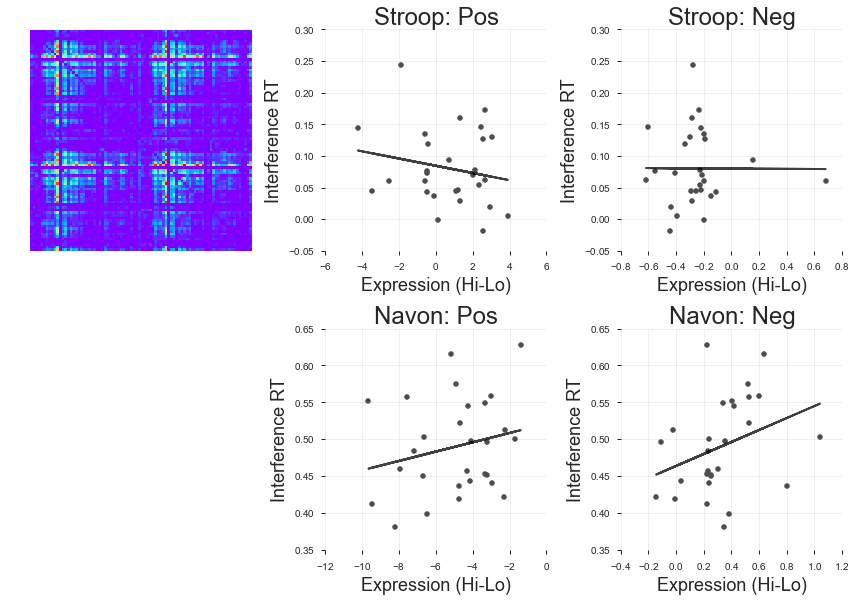





****************************** Subgraph 7 ******************************
    RH_caudalanteriorcingulate
    RH_posteriorcingulate
    LH_posteriorcingulate
    RH_insula
    LH_frontalpole
    RH_isthmuscingulate

     Stroop: Pos: rho: 0.01632 pval: 0.46960 sig: 
     Stroop: Neg: rho: -0.28298 pval: 0.07760 sig: 
      Navon: Pos: rho: -0.22442 pval: 0.12760 sig: 
      Navon: Neg: rho: 0.19838 pval: 0.15860 sig: 


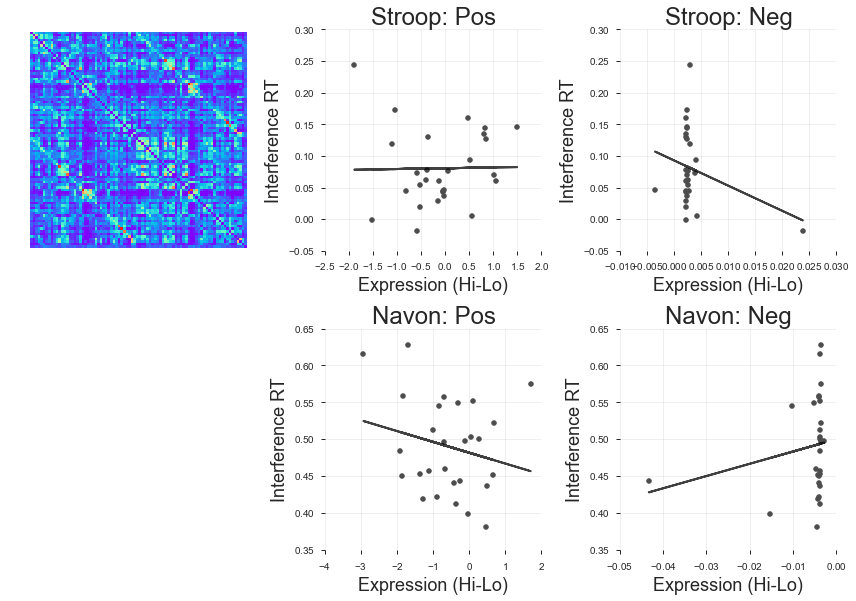





****************************** Subgraph 10 ******************************
    LH_putamen
    RH_putamen
    LH_parsopercularis
    LH_caudate
    RH_parsopercularis
    RH_caudate

     Stroop: Pos: rho: 0.25734 pval: 0.10260 sig: 
     Stroop: Neg: rho: 0.00000 pval: 1.00000 sig: 
      Navon: Pos: rho: 0.16256 pval: 0.20620 sig: 
      Navon: Neg: rho: 0.20723 pval: 0.15240 sig: 


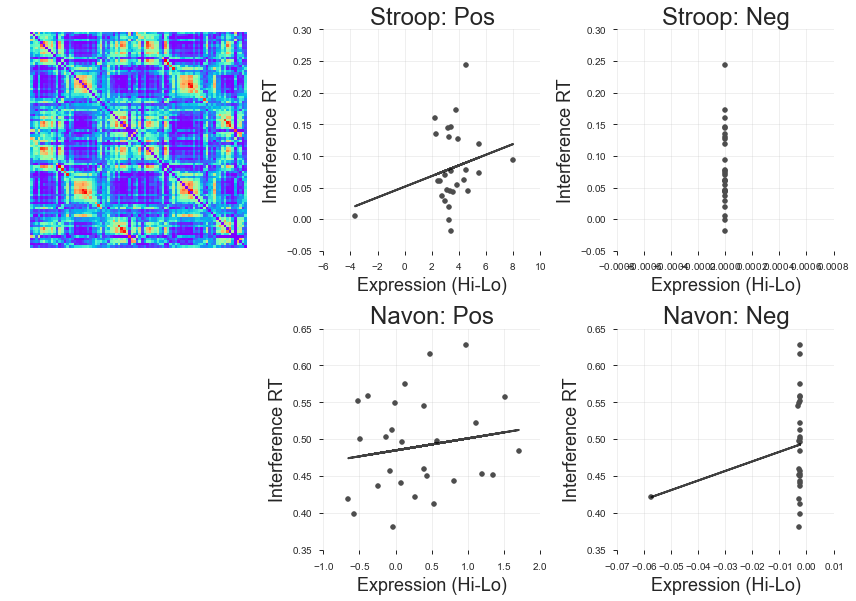





****************************** Subgraph 3 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_cuneus
    LH_lingual
    RH_pericalcarine
    RH_lingual

     Stroop: Pos: rho: 0.22308 pval: 0.12990 sig: 
     Stroop: Neg: rho: -0.12309 pval: 0.26770 sig: 
      Navon: Pos: rho: 0.19274 pval: 0.16790 sig: 
      Navon: Neg: rho: 0.23188 pval: 0.12630 sig: 


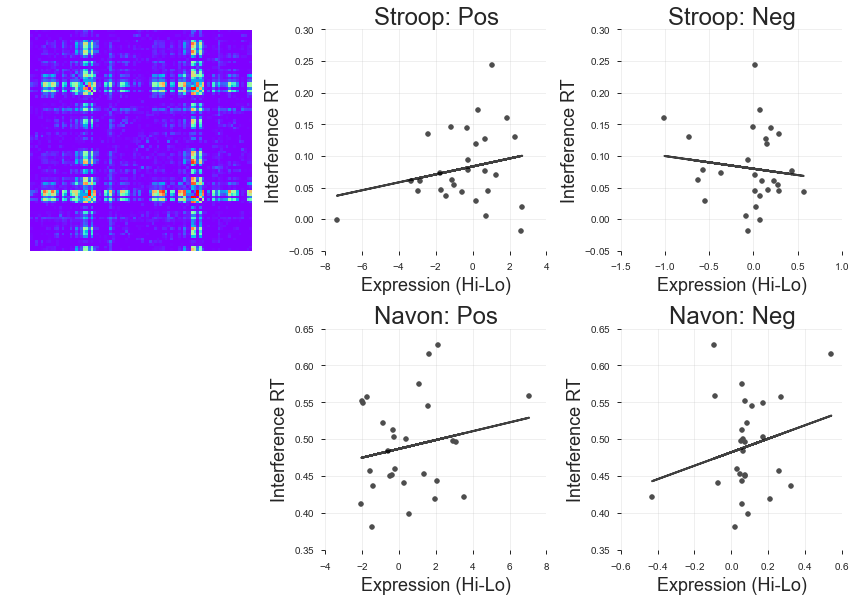





****************************** Subgraph 8 ******************************
    LH_lateraloccipital
    LH_fusiform
    RH_lateraloccipital
    RH_fusiform
    LH_precentral
    LH_superiorparietal

     Stroop: Pos: rho: -0.19602 pval: 0.15500 sig: 
     Stroop: Neg: rho: -0.04124 pval: 0.41150 sig: 
      Navon: Pos: rho: 0.12115 pval: 0.27930 sig: 
      Navon: Neg: rho: 0.00878 pval: 0.48220 sig: 


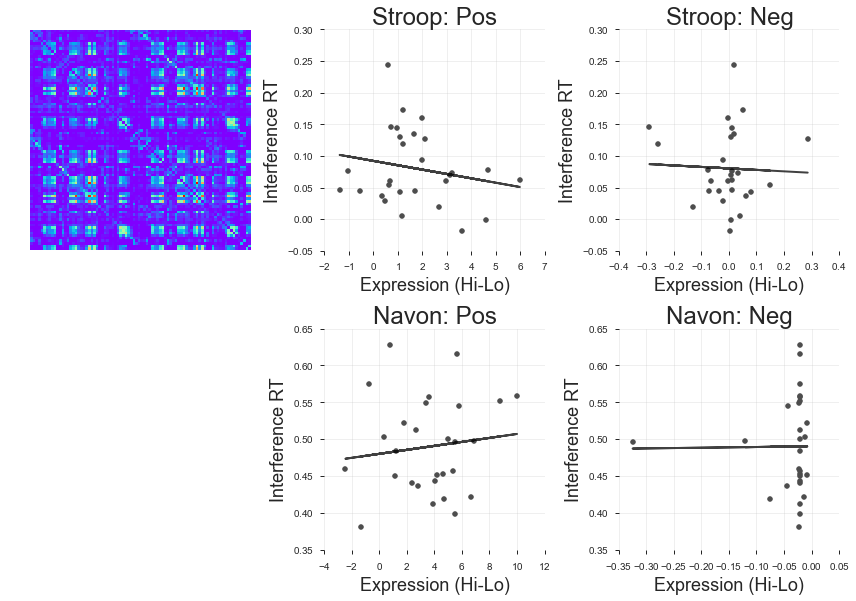





****************************** Subgraph 6 ******************************
    LH_brainstem
    LH_parahippocampal
    RH_parahippocampal
    LH_rostralanteriorcingulate
    LH_thalamusproper
    RH_rostralanteriorcingulate

     Stroop: Pos: rho: 0.19469 pval: 0.16630 sig: 
     Stroop: Neg: rho: 0.05006 pval: 0.39970 sig: 
      Navon: Pos: rho: -0.06633 pval: 0.37640 sig: 
      Navon: Neg: rho: 0.06379 pval: 0.36580 sig: 


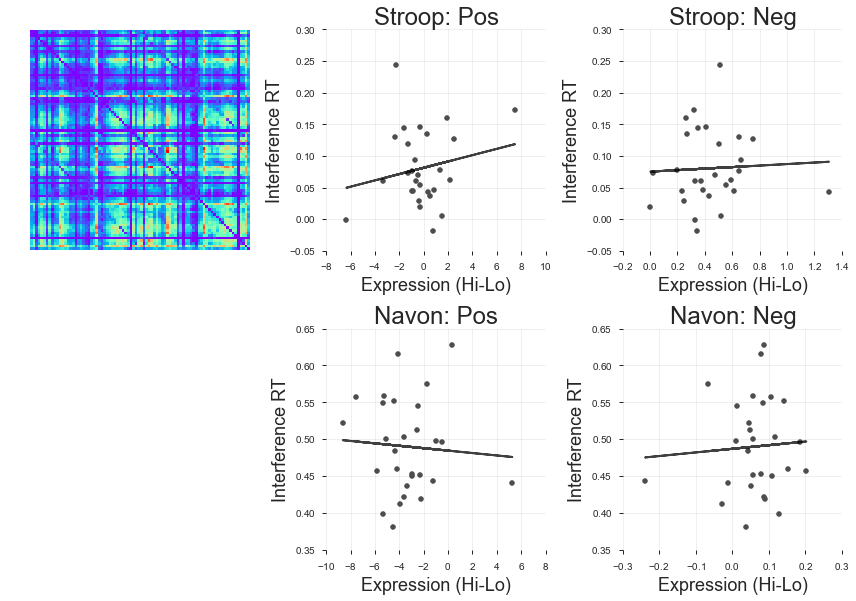





****************************** Subgraph 1 ******************************
    LH_isthmuscingulate
    RH_isthmuscingulate
    LH_precuneus
    RH_precuneus
    LH_parahippocampal
    RH_parahippocampal

     Stroop: Pos: rho: -0.18335 pval: 0.18070 sig: 
     Stroop: Neg: rho: 0.01627 pval: 0.46730 sig: 
      Navon: Pos: rho: 0.05735 pval: 0.39540 sig: 
      Navon: Neg: rho: -0.18102 pval: 0.17680 sig: 


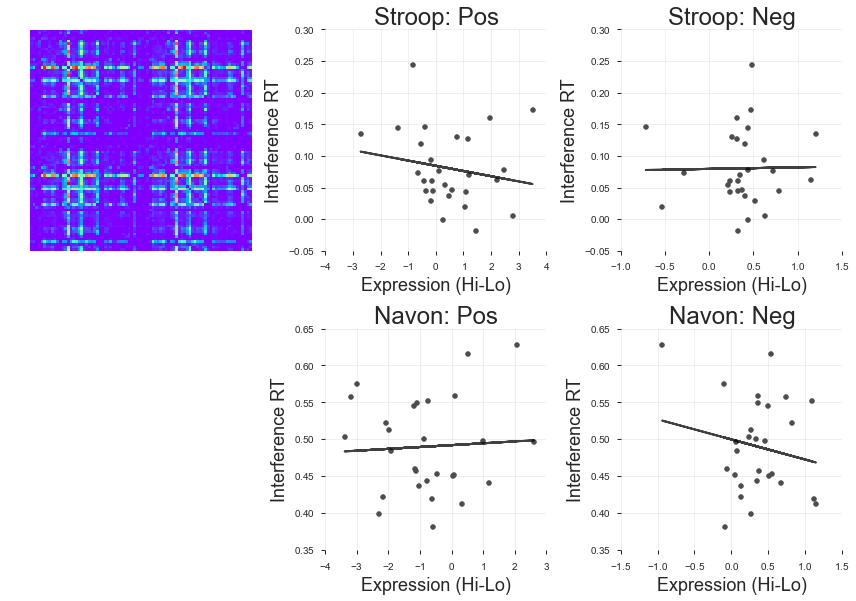





****************************** Subgraph 13 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_pericalcarine
    RH_cuneus
    LH_lingual
    RH_lingual

     Stroop: Pos: rho: 0.16684 pval: 0.19650 sig: 
     Stroop: Neg: rho: -0.06727 pval: 0.37140 sig: 
      Navon: Pos: rho: -0.15208 pval: 0.23120 sig: 
      Navon: Neg: rho: 0.03434 pval: 0.43480 sig: 


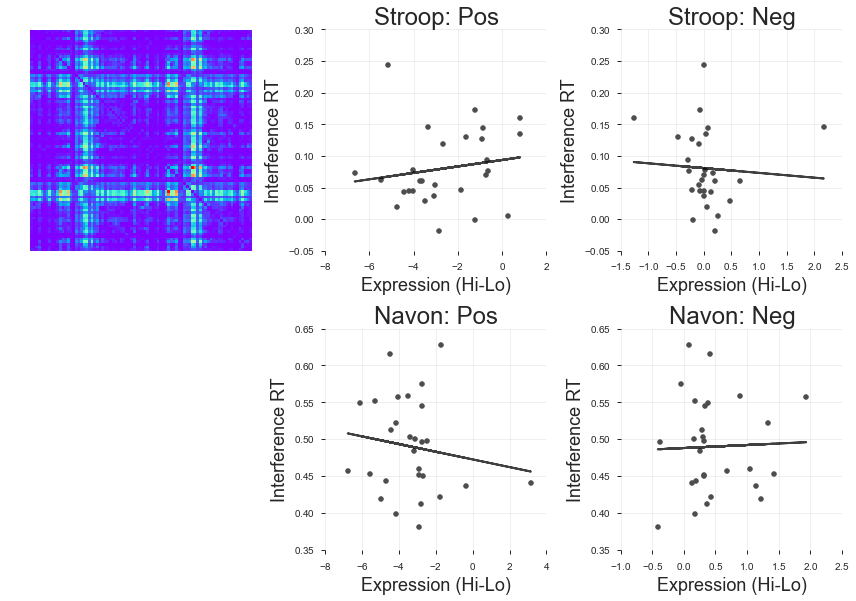





****************************** Subgraph 11 ******************************
    LH_rostralanteriorcingulate
    RH_rostralanteriorcingulate
    LH_frontalpole
    LH_medialorbitofrontal
    LH_lateraloccipital
    RH_lateraloccipital

     Stroop: Pos: rho: 0.11295 pval: 0.28310 sig: 
     Stroop: Neg: rho: -0.05736 pval: 0.38720 sig: 
      Navon: Pos: rho: 0.02857 pval: 0.44360 sig: 
      Navon: Neg: rho: 0.10408 pval: 0.30430 sig: 


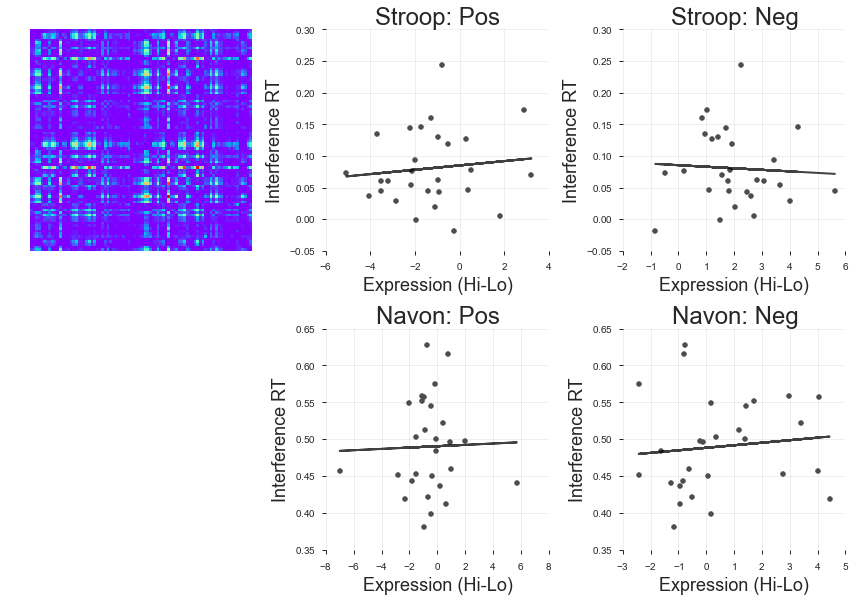





****************************** Subgraph 5 ******************************
    RH_postcentral
    LH_medialorbitofrontal
    LH_paracentral
    LH_rostralanteriorcingulate
    LH_postcentral
    RH_paracentral

     Stroop: Pos: rho: -0.06427 pval: 0.38350 sig: 
     Stroop: Neg: rho: 0.07576 pval: 0.35020 sig: 
      Navon: Pos: rho: 0.10191 pval: 0.30950 sig: 
      Navon: Neg: rho: -0.05674 pval: 0.39180 sig: 


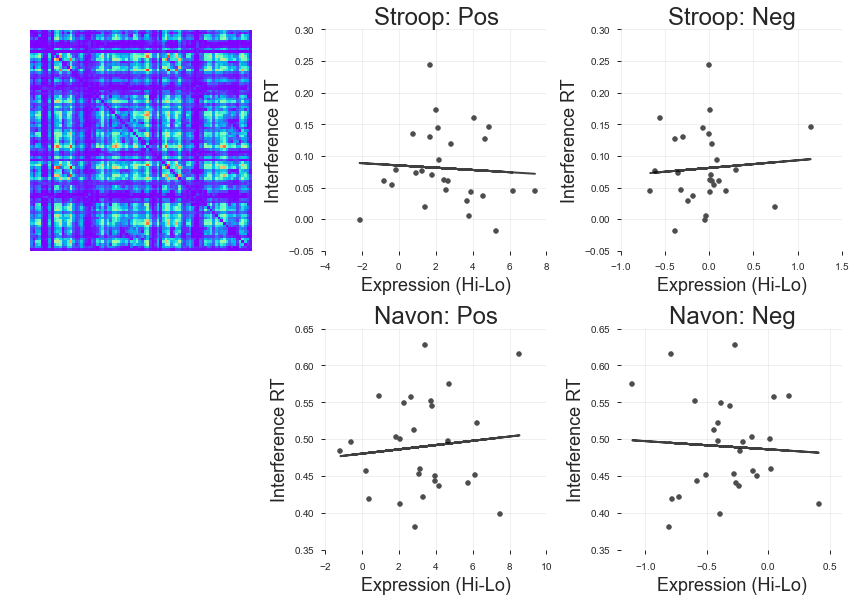

In [57]:
%matplotlib inline

path_cfg_expr = glob.glob('{}/NMF_Optimization.CfgMatr.npz'.format(path_InpData))[0]
df_cfg = np.load(path_cfg_expr, mmap_mode='r')
cfg_key = df_cfg['cfg_key']
key_grp = {'Stroop': {'Pos': ['adj_hi_pos_Stroop', 'adj_lo_pos_Stroop'],
                      'Neg': ['adj_hi_neg_Stroop', 'adj_lo_neg_Stroop']},
           'Navon' : {'Pos': ['adj_hi_pos_Navon', 'adj_lo_pos_Navon'],
                      'Neg': ['adj_hi_neg_Navon', 'adj_lo_neg_Navon']}}
grp_order = ['Stroop', 'Navon']
key_order = ['Pos', 'Neg']
           
beh_grp = {'Stroop': [stroop_move, stroop_cost_rt],
           'Navon': [navon_move, navon_cost_rt]}

sel_fac_ix = np.arange(n_fac)[sel_fac_within_sig]

# Populate plot database
plot_list = []
for fac_ii in sel_fac_ix:
    plot_dict = {'subgraph': conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]),
                 'subplot': []}
                 
    for grp in grp_order: #key_grp.keys():        
        for key in key_order: #key_grp[grp].keys():
            key_hi_ix = np.flatnonzero(cfg_key == key_grp[grp][key][0])
            key_lo_ix = np.flatnonzero(cfg_key == key_grp[grp][key][1])
            
            subj_coef_hi = fac_coef[fac_ii, key_hi_ix].reshape(-1, 6)
            subj_coef_lo = fac_coef[fac_ii, key_lo_ix].reshape(-1, 6)            
            mean_subj_coef = np.mean(subj_coef_hi, axis=1) - np.mean(subj_coef_lo, axis=1)
            
            m, b, _, _, _ = stats.linregress(beh_grp[grp][0], mean_subj_coef)
            real_mean_subj_coef_nomove = mean_subj_coef - beh_grp[grp][0]*m+b
            
            m, b, _, _, _ = stats.linregress(beh_grp[grp][0], beh_grp[grp][1])
            beh_score_nomove = beh_grp[grp][1] - beh_grp[grp][0]*m+b            
            
            real_m, real_b, real_rho, _, _ = stats.linregress(real_mean_subj_coef_nomove, beh_score_nomove)

            if real_rho == 0:
                pval = 1.0
            else:
                n_count = 0
                n_null = 10000
                for rnd_i in xrange(n_null):
                    null_fac_ix = np.random.randint(0, n_fac)
                    null_key_hi_ix = np.random.randint(0, n_obs, size=len(key_hi_ix))
                    null_key_lo_ix = np.random.randint(0, n_obs, size=len(key_lo_ix))
                    
                    subj_coef_hi = null_fac_coef[null_fac_ix, null_key_hi_ix].reshape(-1, 6)
                    subj_coef_lo = null_fac_coef[null_fac_ix, null_key_lo_ix].reshape(-1, 6)
                    mean_subj_coef = np.mean(subj_coef_hi, axis=1) - np.mean(subj_coef_lo, axis=1)

                    m, b, _, _, _ = stats.linregress(beh_grp[grp][0], mean_subj_coef)
                    mean_subj_coef_nomove = mean_subj_coef - beh_grp[grp][0]*m+b

                    m, b, rho, _, _ = stats.linregress(mean_subj_coef_nomove, beh_score_nomove)

                    if (real_rho < 0) & (rho < real_rho):
                        n_count += 1

                    if (real_rho > 0) & (rho > real_rho):
                        n_count += 1

                pval = float(n_count) / float(n_null)                    
            
            subplot_dict = {'title': '{}: {}'.format(grp, key),
                            'xlabel': key,
                            'distrib': (real_mean_subj_coef_nomove, beh_score_nomove),
                            'stats': {}}
            subplot_dict['stats'] = {'rho': real_rho,
                                     'pval': pval,
                                     'slope': real_m,
                                     "interc": real_b,
                                     'sig': ''}       
            
            plot_dict['subplot'].append(subplot_dict)
    plot_list.append(plot_dict)

# Benjamini-Hochberg Multiple Comparisons
all_pval = np.sort([fac_subp['stats']['pval']
                    for fac_plot in plot_list
                    for fac_subp in fac_plot['subplot']])[::-1]
alpha = 0.05
n_comp = len(all_pval)
for ix, i in enumerate(range(n_comp, 0, -1)):
    adj_alpha = i/n_comp*alpha
    if all_pval[ix] < adj_alpha:
        break
print('%0.10f' % adj_alpha)

# Re-adjust significant indicator and re-order subgraphs
min_fac_pval = []
for fac_plot in plot_list:
    pval_list = []
    for fac_subp in fac_plot['subplot']:
        if fac_subp['stats']['pval'] < adj_alpha:
            fac_subp['stats']['sig'] = '*'
        pval_list.append(fac_subp['stats']['pval'])
    min_fac_pval.append(np.min(pval_list))
sel_fac_ord = np.argsort(min_fac_pval)

# Plot each result
for fac_ix in sel_fac_ord:
    fac_plot = plot_list[fac_ix]
    
    plt.figure(figsize=(12,12))
    ax = plt.subplot(3, 3, 1)
    ax.matshow(fac_plot['subgraph'], cmap='rainbow')
    ax.set_axis_off()
    ax_list = [2,3,5,6]

    print('****************************** Subgraph {} ******************************'.format(fac_ix+1))    
    sort_roi = np.argsort(np.sum(fac_plot['subgraph'], axis=0))[::-1]
    print('    ' + '\n    '.join([all_roi_names[sort_roi[i]] for i in xrange(6)]))
    print('')

    for subp_ii, fac_subp in enumerate(fac_plot['subplot']):
        ax = plt.subplot(3, 3, ax_list[subp_ii])
        
        ax.plot(fac_subp['distrib'][0], 
                fac_subp['stats']['slope']*fac_subp['distrib'][0]+fac_subp['stats']['interc'],
                color='k', alpha=0.75)
        ax.scatter(fac_subp['distrib'][0], fac_subp['distrib'][1],
                   color=[0.3, 0.3, 0.3])

        ax.set_xlabel('Expression (Hi-Lo)')
        ax.set_ylabel('Cost RT')
        ax.set_title(fac_subp['title'])
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')


        print('    %12s: rho: %3.5f pval: %3.5f sig: %s' % 
              (fac_subp['title'],
               fac_subp['stats']['rho'],
               fac_subp['stats']['pval'],
               fac_subp['stats']['sig']))
            
    plt.show()
    print('\n\n\n')

### Predicting Interference Accuracy (Hi)

0.0009615385
****************************** Subgraph 6 ******************************
    LH_brainstem
    LH_parahippocampal
    RH_parahippocampal
    LH_rostralanteriorcingulate
    LH_thalamusproper
    RH_rostralanteriorcingulate

    Stroop: Hi_Pos: rho: -0.39890 pval: 0.02420 sig: 
    Stroop: Hi_Neg: rho: 0.16365 pval: 0.20370 sig: 
    Navon: Hi_Pos: rho: 0.03411 pval: 0.46950 sig: 
    Navon: Hi_Neg: rho: 0.04684 pval: 0.44330 sig: 


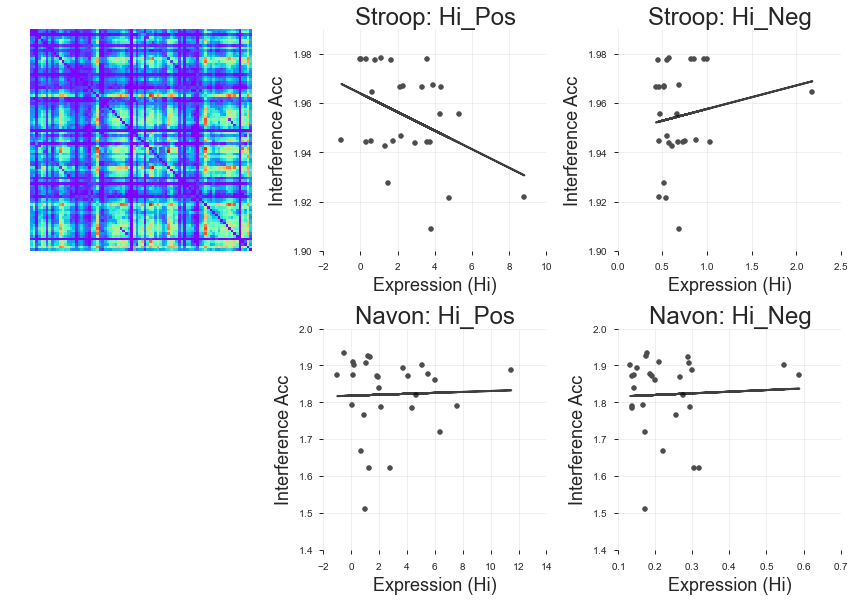





****************************** Subgraph 4 ******************************
    RH_caudalmiddlefrontal
    RH_inferiorparietal
    RH_rostralmiddlefrontal
    RH_parsorbitalis
    LH_lateraloccipital
    RH_middletemporal

    Stroop: Hi_Pos: rho: -0.38618 pval: 0.03280 sig: 
    Stroop: Hi_Neg: rho: 0.01316 pval: 0.48850 sig: 
    Navon: Hi_Pos: rho: -0.41922 pval: 0.02730 sig: 
    Navon: Hi_Neg: rho: 0.31593 pval: 0.03360 sig: 


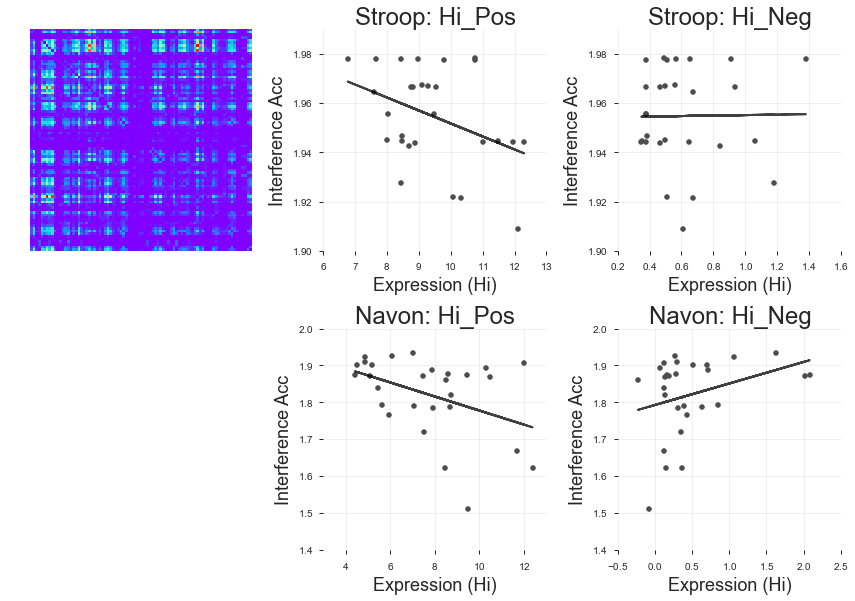





****************************** Subgraph 8 ******************************
    LH_lateraloccipital
    LH_fusiform
    RH_lateraloccipital
    RH_fusiform
    LH_precentral
    LH_superiorparietal

    Stroop: Hi_Pos: rho: 0.16803 pval: 0.20320 sig: 
    Stroop: Hi_Neg: rho: 0.32658 pval: 0.04130 sig: 
    Navon: Hi_Pos: rho: -0.02413 pval: 0.42210 sig: 
    Navon: Hi_Neg: rho: 0.09313 pval: 0.34770 sig: 


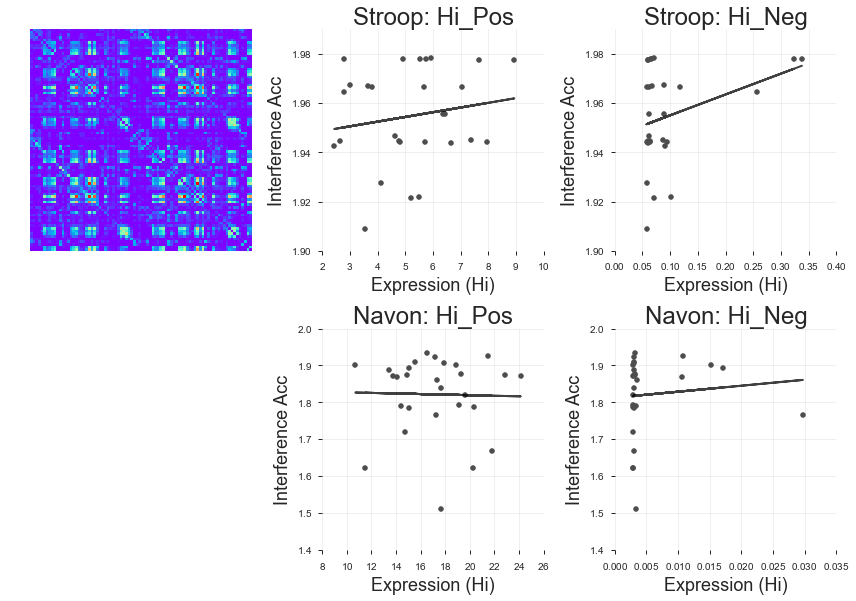





****************************** Subgraph 5 ******************************
    RH_postcentral
    LH_medialorbitofrontal
    LH_paracentral
    LH_rostralanteriorcingulate
    LH_postcentral
    RH_paracentral

    Stroop: Hi_Pos: rho: 0.05444 pval: 0.41770 sig: 
    Stroop: Hi_Neg: rho: 0.17545 pval: 0.19400 sig: 
    Navon: Hi_Pos: rho: -0.03593 pval: 0.39340 sig: 
    Navon: Hi_Neg: rho: 0.28995 pval: 0.05040 sig: 


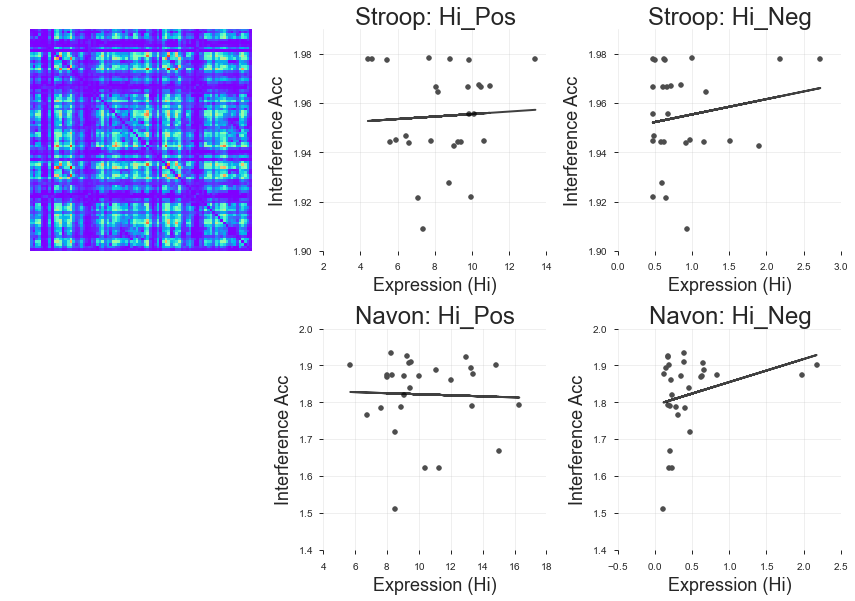





****************************** Subgraph 11 ******************************
    LH_rostralanteriorcingulate
    RH_rostralanteriorcingulate
    LH_frontalpole
    LH_medialorbitofrontal
    LH_lateraloccipital
    RH_lateraloccipital

    Stroop: Hi_Pos: rho: -0.24319 pval: 0.11500 sig: 
    Stroop: Hi_Neg: rho: 0.19138 pval: 0.17000 sig: 
    Navon: Hi_Pos: rho: -0.09225 pval: 0.29780 sig: 
    Navon: Hi_Neg: rho: 0.27787 pval: 0.05520 sig: 


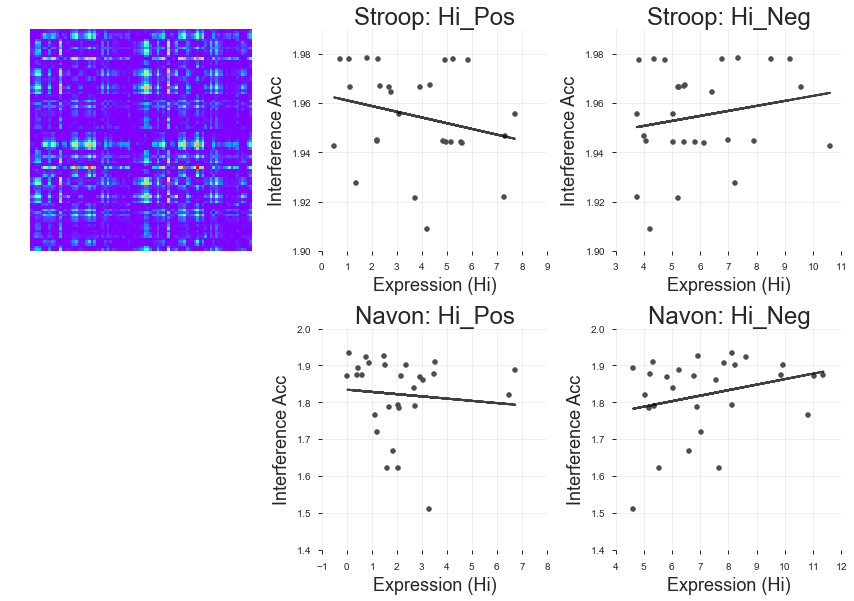





****************************** Subgraph 12 ******************************
    LH_parsorbitalis
    RH_parsorbitalis
    LH_parstriangularis
    LH_middletemporal
    LH_rostralanteriorcingulate
    RH_middletemporal

    Stroop: Hi_Pos: rho: 0.20727 pval: 0.16000 sig: 
    Stroop: Hi_Neg: rho: 0.12945 pval: 0.27410 sig: 
    Navon: Hi_Pos: rho: 0.28225 pval: 0.05540 sig: 
    Navon: Hi_Neg: rho: -0.11004 pval: 0.26540 sig: 


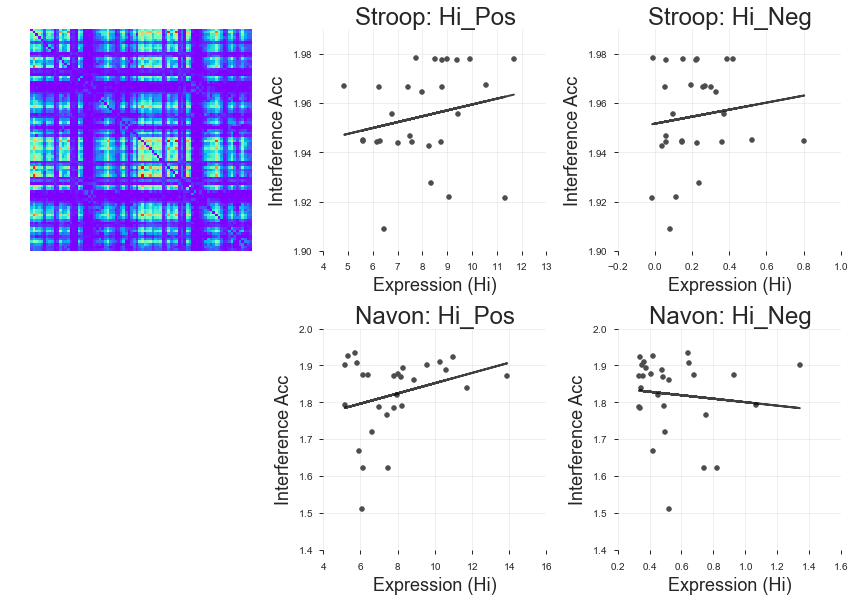





****************************** Subgraph 13 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_pericalcarine
    RH_cuneus
    LH_lingual
    RH_lingual

    Stroop: Hi_Pos: rho: 0.04763 pval: 0.42650 sig: 
    Stroop: Hi_Neg: rho: -0.10995 pval: 0.28580 sig: 
    Navon: Hi_Pos: rho: 0.05990 pval: 0.42110 sig: 
    Navon: Hi_Neg: rho: 0.21324 pval: 0.13220 sig: 


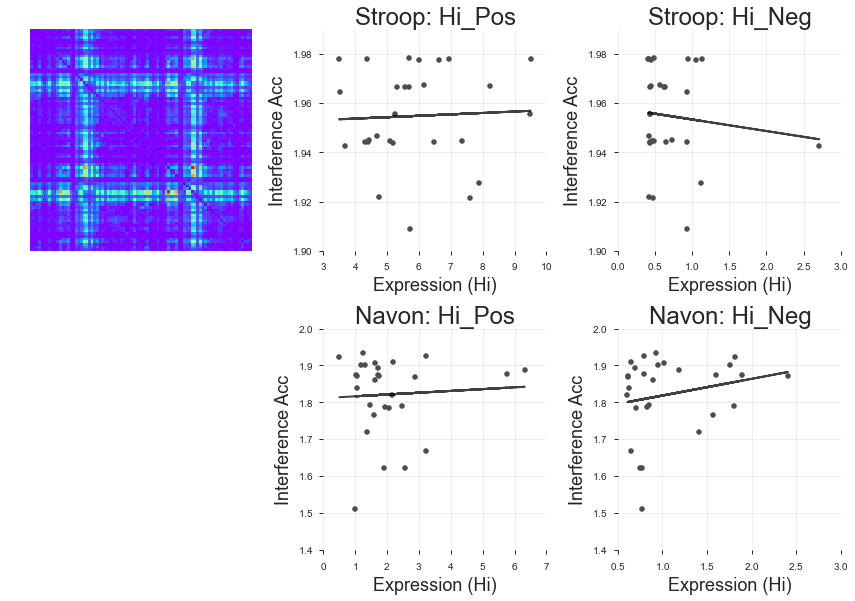





****************************** Subgraph 9 ******************************
    LH_paracentral
    RH_paracentral
    RH_posteriorcingulate
    LH_posteriorcingulate
    LH_caudalanteriorcingulate
    LH_precentral

    Stroop: Hi_Pos: rho: -0.02853 pval: 0.43490 sig: 
    Stroop: Hi_Neg: rho: -0.10715 pval: 0.29590 sig: 
    Navon: Hi_Pos: rho: -0.20525 pval: 0.15320 sig: 
    Navon: Hi_Neg: rho: 0.05772 pval: 0.42780 sig: 


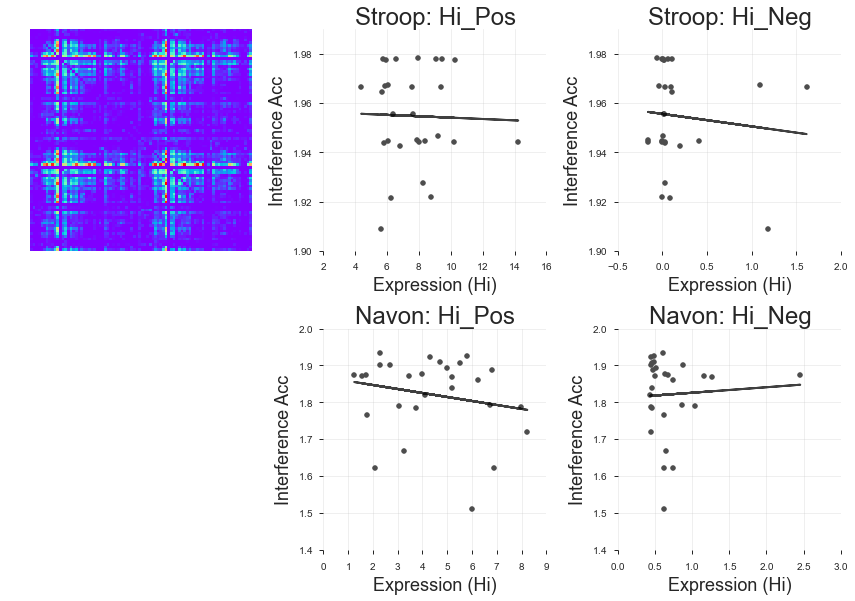





****************************** Subgraph 3 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_cuneus
    LH_lingual
    RH_pericalcarine
    RH_lingual

    Stroop: Hi_Pos: rho: 0.07891 pval: 0.35400 sig: 
    Stroop: Hi_Neg: rho: -0.18035 pval: 0.18520 sig: 
    Navon: Hi_Pos: rho: -0.16989 pval: 0.19500 sig: 
    Navon: Hi_Neg: rho: 0.09143 pval: 0.35260 sig: 


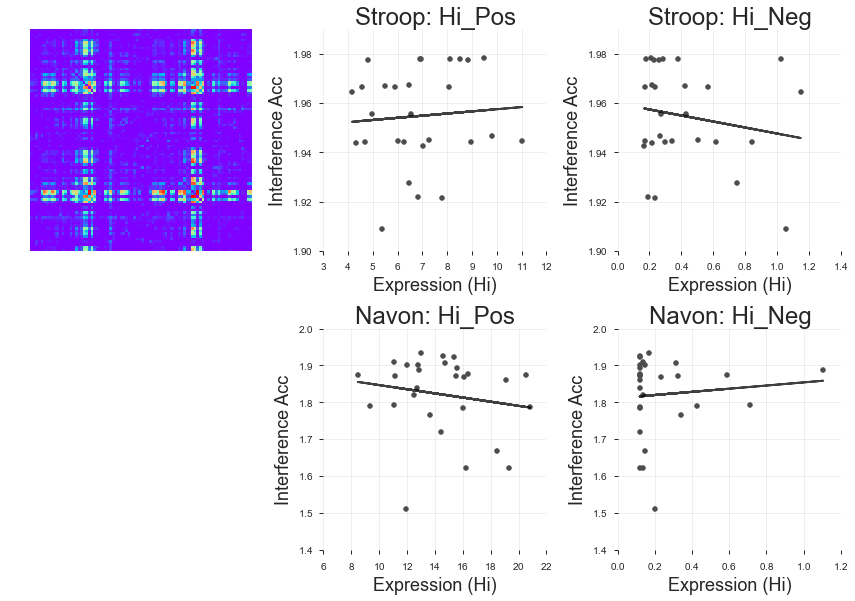





****************************** Subgraph 10 ******************************
    LH_putamen
    RH_putamen
    LH_parsopercularis
    LH_caudate
    RH_parsopercularis
    RH_caudate

    Stroop: Hi_Pos: rho: -0.06653 pval: 0.36230 sig: 
    Stroop: Hi_Neg: rho: 0.00000 pval: 1.00000 sig: 
    Navon: Hi_Pos: rho: 0.17774 pval: 0.19390 sig: 
    Navon: Hi_Neg: rho: 0.00000 pval: 1.00000 sig: 


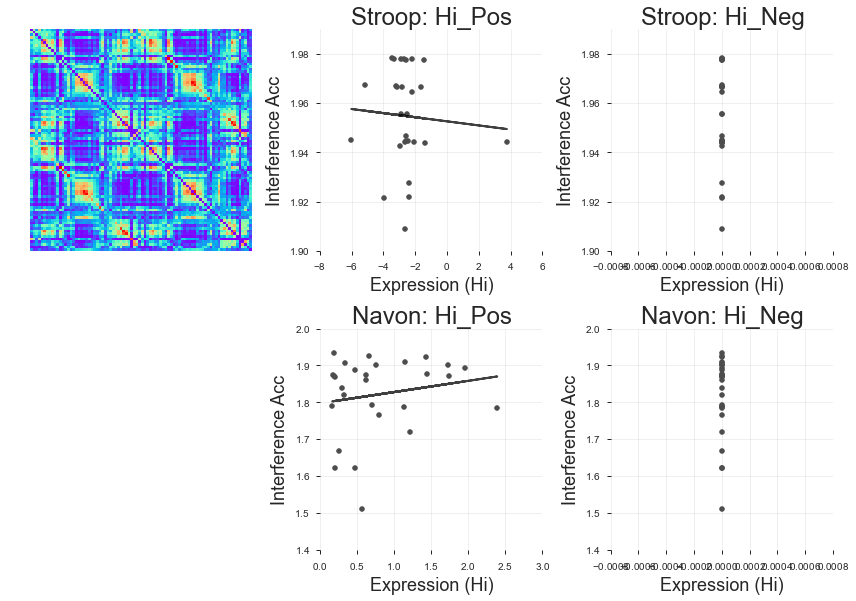





****************************** Subgraph 7 ******************************
    RH_caudalanteriorcingulate
    RH_posteriorcingulate
    LH_posteriorcingulate
    RH_insula
    LH_frontalpole
    RH_isthmuscingulate

    Stroop: Hi_Pos: rho: -0.13508 pval: 0.24380 sig: 
    Stroop: Hi_Neg: rho: 0.11812 pval: 0.28470 sig: 
    Navon: Hi_Pos: rho: 0.04446 pval: 0.44750 sig: 
    Navon: Hi_Neg: rho: 0.10181 pval: 0.33630 sig: 


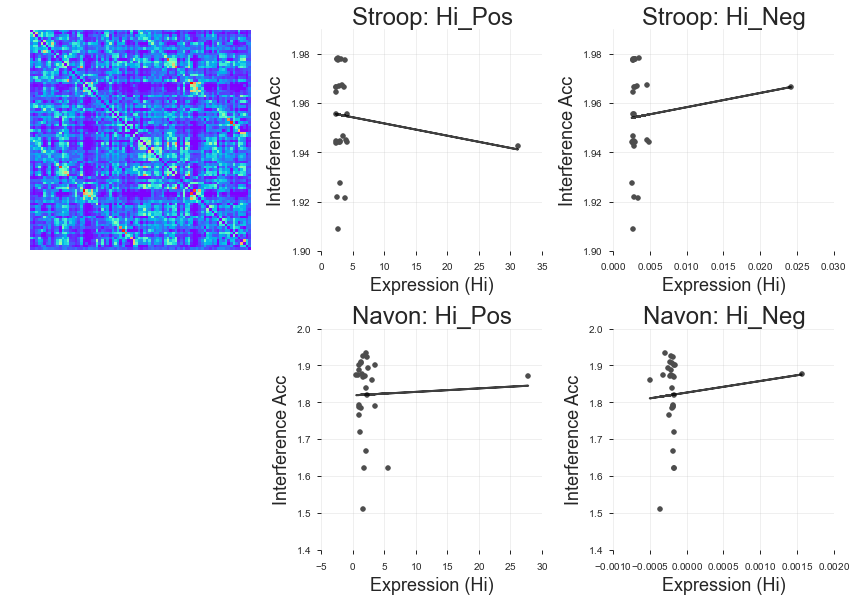





****************************** Subgraph 1 ******************************
    LH_isthmuscingulate
    RH_isthmuscingulate
    LH_precuneus
    RH_precuneus
    LH_parahippocampal
    RH_parahippocampal

    Stroop: Hi_Pos: rho: 0.10408 pval: 0.31450 sig: 
    Stroop: Hi_Neg: rho: 0.02079 pval: 0.47980 sig: 
    Navon: Hi_Pos: rho: -0.10077 pval: 0.28990 sig: 
    Navon: Hi_Neg: rho: 0.10202 pval: 0.33220 sig: 


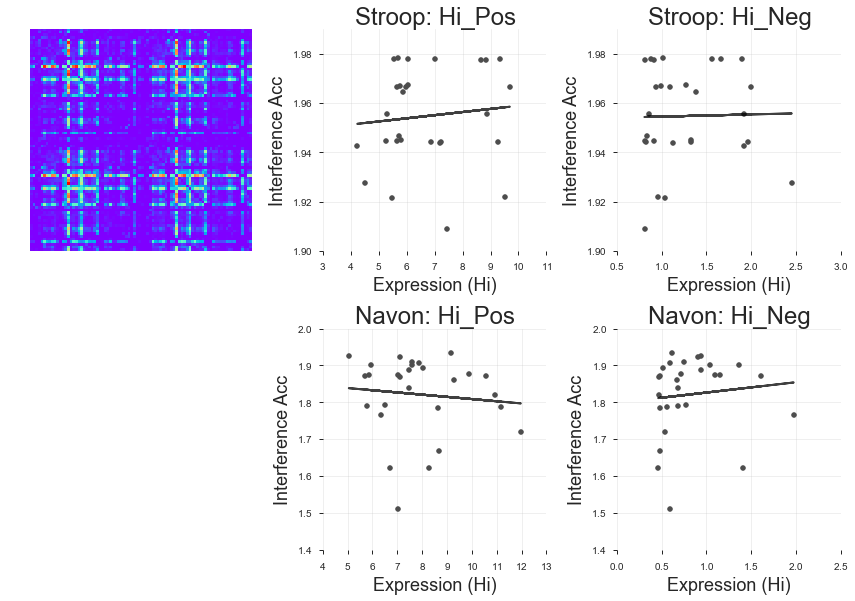





****************************** Subgraph 2 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_posteriorcingulate
    RH_rostralmiddlefrontal
    RH_caudalanteriorcingulate
    LH_caudalanteriorcingulate

    Stroop: Hi_Pos: rho: 0.02721 pval: 0.45460 sig: 
    Stroop: Hi_Neg: rho: 0.00000 pval: 1.00000 sig: 
    Navon: Hi_Pos: rho: -0.01804 pval: 0.42820 sig: 
    Navon: Hi_Neg: rho: 0.00000 pval: 1.00000 sig: 


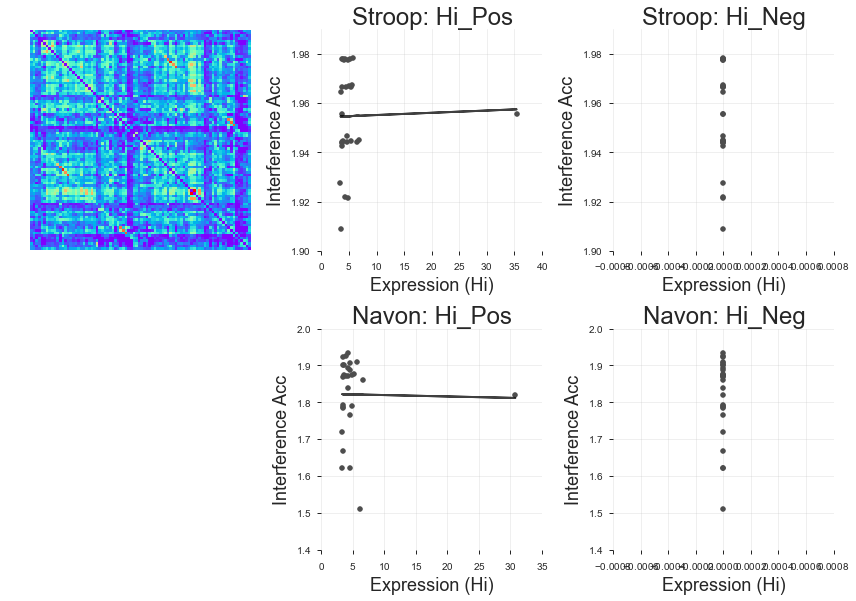

In [59]:
%matplotlib inline

path_cfg_expr = glob.glob('{}/NMF_Optimization.CfgMatr.npz'.format(path_InpData))[0]
df_cfg = np.load(path_cfg_expr, mmap_mode='r')
cfg_key = df_cfg['cfg_key']
key_grp = {'Stroop': {'Hi_Pos': ['adj_hi_pos_Stroop'],
                      'Hi_Neg': ['adj_hi_neg_Stroop']},
           'Navon' : {'Hi_Pos': ['adj_hi_pos_Navon'],
                      'Hi_Neg': ['adj_hi_neg_Navon']}}
grp_order = ['Stroop', 'Navon']
key_order = ['Hi_Pos', 'Hi_Neg']
           
beh_grp = {'Stroop': [stroop_move, stroop_interf_acc],
           'Navon': [navon_move, navon_interf_acc]}

sel_fac_ix = np.arange(n_fac)[sel_fac_within_sig]

# Populate plot database
plot_list = []
for fac_ii in sel_fac_ix:
    plot_dict = {'subgraph': conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]),
                 'subplot': []}
                 
    for grp in grp_order: #key_grp.keys():        
        for key in key_order: #key_grp[grp].keys():
            key_ix = np.flatnonzero(cfg_key == key_grp[grp][key][0])
            
            subj_coef = fac_coef[fac_ii, key_ix].reshape(-1, 6)
            mean_subj_coef = np.mean(subj_coef, axis=1)
            
            m, b, _, _, _ = stats.linregress(beh_grp[grp][0], mean_subj_coef)
            real_mean_subj_coef_nomove = mean_subj_coef - beh_grp[grp][0]*m+b
            
            m, b, _, _, _ = stats.linregress(beh_grp[grp][0], beh_grp[grp][1])
            beh_score_nomove = beh_grp[grp][1] - beh_grp[grp][0]*m+b            
            
            real_m, real_b, real_rho, _, _ = stats.linregress(real_mean_subj_coef_nomove, beh_score_nomove)

            if real_rho == 0:
                pval = 1.0
            else:
                n_count = 0
                n_null = 10000
                for rnd_i in xrange(n_null):
                    null_fac_ix = np.random.randint(0, n_fac)
                    null_key_ix = np.random.randint(0, n_obs, size=len(key_ix))
                    subj_coef = null_fac_coef[null_fac_ix, null_key_ix].reshape(-1, 6)
                    mean_subj_coef = np.mean(subj_coef, axis=1)

                    m, b, _, _, _ = stats.linregress(beh_grp[grp][0], mean_subj_coef)
                    mean_subj_coef_nomove = mean_subj_coef - beh_grp[grp][0]*m+b

                    m, b, rho, _, _ = stats.linregress(mean_subj_coef_nomove, beh_score_nomove)

                    if (real_rho < 0) & (rho < real_rho):
                        n_count += 1

                    if (real_rho > 0) & (rho > real_rho):
                        n_count += 1

                pval = float(n_count) / float(n_null)                    
            
            subplot_dict = {'title': '{}: {}'.format(grp, key),
                            'xlabel': key,
                            'distrib': (real_mean_subj_coef_nomove, beh_score_nomove),
                            'stats': {}}
            subplot_dict['stats'] = {'rho': real_rho,
                                     'pval': pval,
                                     'slope': real_m,
                                     "interc": real_b,
                                     'sig': ''}       
            
            plot_dict['subplot'].append(subplot_dict)
    plot_list.append(plot_dict)

# Benjamini-Hochberg Multiple Comparisons
all_pval = np.sort([fac_subp['stats']['pval']
                    for fac_plot in plot_list
                    for fac_subp in fac_plot['subplot']])[::-1]
alpha = 0.05
n_comp = len(all_pval)
for ix, i in enumerate(range(n_comp, 0, -1)):
    adj_alpha = i/n_comp*alpha
    if all_pval[ix] < adj_alpha:
        break
print('%0.10f' % adj_alpha)

# Re-adjust significant indicator and re-order subgraphs
min_fac_pval = []
for fac_plot in plot_list:
    pval_list = []
    for fac_subp in fac_plot['subplot']:
        if fac_subp['stats']['pval'] < adj_alpha:
            fac_subp['stats']['sig'] = '*'
        pval_list.append(fac_subp['stats']['pval'])
    min_fac_pval.append(np.min(pval_list))
sel_fac_ord = np.argsort(min_fac_pval)

# Plot each result
for fac_ix in sel_fac_ord:
    fac_plot = plot_list[fac_ix]
    
    plt.figure(figsize=(12,12))
    ax = plt.subplot(3, 3, 1)
    ax.matshow(fac_plot['subgraph'], cmap='rainbow')
    ax.set_axis_off()
    ax_list = [2,3,5,6]

    print('****************************** Subgraph {} ******************************'.format(fac_ix+1))    
    sort_roi = np.argsort(np.sum(fac_plot['subgraph'], axis=0))[::-1]
    print('    ' + '\n    '.join([all_roi_names[sort_roi[i]] for i in xrange(6)]))
    print('')

    for subp_ii, fac_subp in enumerate(fac_plot['subplot']):
        ax = plt.subplot(3, 3, ax_list[subp_ii])
        
        ax.plot(fac_subp['distrib'][0], 
                fac_subp['stats']['slope']*fac_subp['distrib'][0]+fac_subp['stats']['interc'],
                color='k', alpha=0.75)
        ax.scatter(fac_subp['distrib'][0], fac_subp['distrib'][1],
                   color=[0.3, 0.3, 0.3])

        ax.set_xlabel('Expression (Hi)')
        ax.set_ylabel('Interference Acc')
        ax.set_title(fac_subp['title'])
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')


        print('    %12s: rho: %3.5f pval: %3.5f sig: %s' % 
              (fac_subp['title'],
               fac_subp['stats']['rho'],
               fac_subp['stats']['pval'],
               fac_subp['stats']['sig']))
            
    plt.show()
    print('\n\n\n')

### Predicting Cost Accuracy (Hi-Lo)

0.0009615385
****************************** Subgraph 5 ******************************
    RH_postcentral
    LH_medialorbitofrontal
    LH_paracentral
    LH_rostralanteriorcingulate
    LH_postcentral
    RH_paracentral

     Stroop: Pos: rho: 0.07376 pval: 0.35620 sig: 
     Stroop: Neg: rho: 0.18356 pval: 0.17480 sig: 
      Navon: Pos: rho: 0.20251 pval: 0.15430 sig: 
      Navon: Neg: rho: -0.36018 pval: 0.03330 sig: 


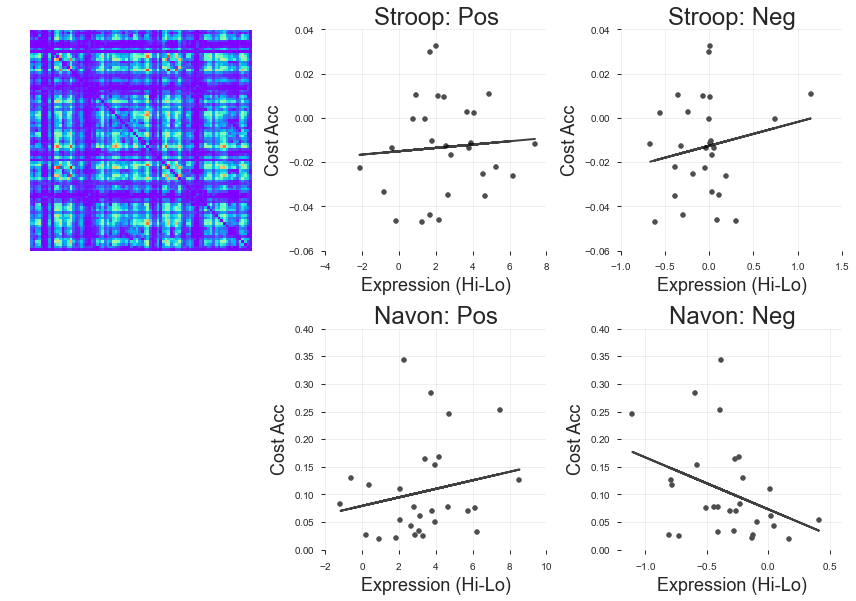





****************************** Subgraph 9 ******************************
    LH_paracentral
    RH_paracentral
    RH_posteriorcingulate
    LH_posteriorcingulate
    LH_caudalanteriorcingulate
    LH_precentral

     Stroop: Pos: rho: -0.01075 pval: 0.47600 sig: 
     Stroop: Neg: rho: -0.32764 pval: 0.04960 sig: 
      Navon: Pos: rho: -0.01835 pval: 0.45780 sig: 
      Navon: Neg: rho: 0.02894 pval: 0.44630 sig: 


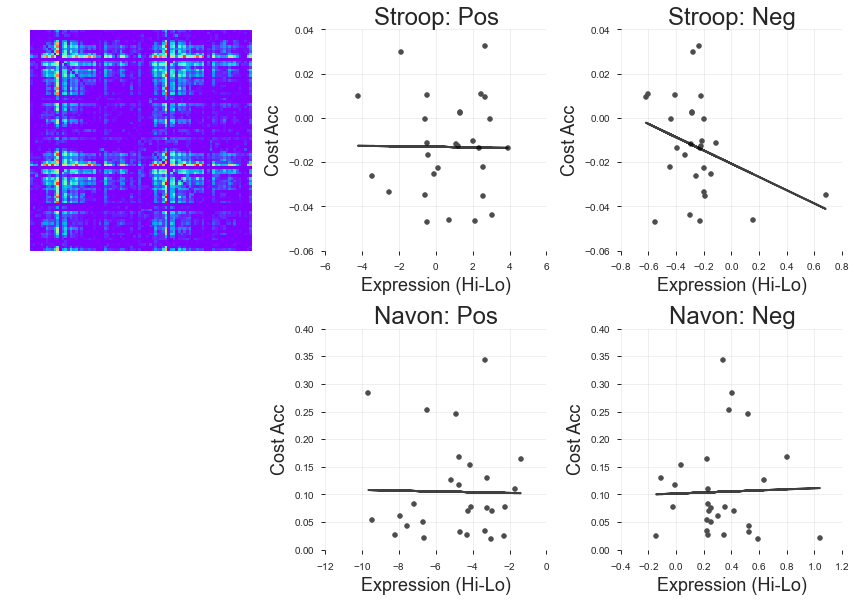





****************************** Subgraph 10 ******************************
    LH_putamen
    RH_putamen
    LH_parsopercularis
    LH_caudate
    RH_parsopercularis
    RH_caudate

     Stroop: Pos: rho: -0.07776 pval: 0.35100 sig: 
     Stroop: Neg: rho: 0.00000 pval: 1.00000 sig: 
      Navon: Pos: rho: -0.31921 pval: 0.05750 sig: 
      Navon: Neg: rho: 0.18221 pval: 0.18210 sig: 


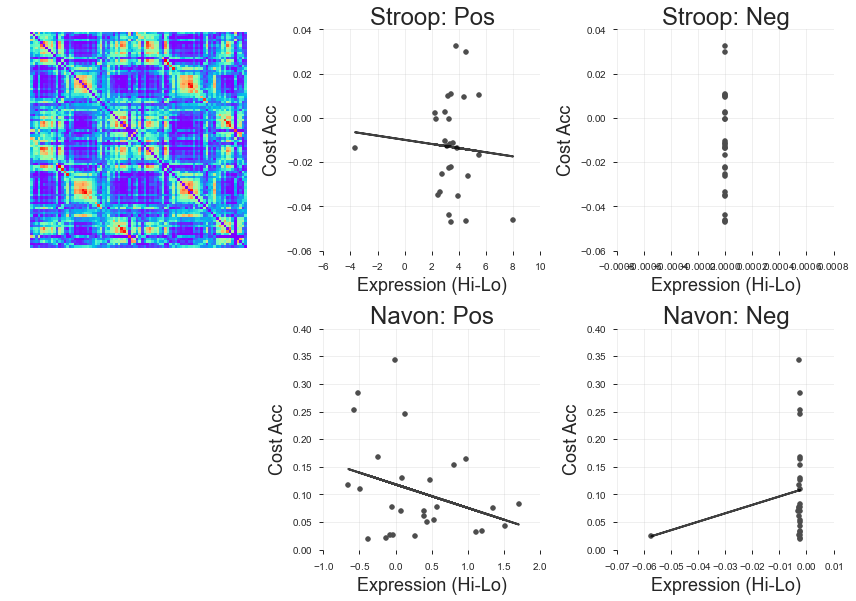





****************************** Subgraph 6 ******************************
    LH_brainstem
    LH_parahippocampal
    RH_parahippocampal
    LH_rostralanteriorcingulate
    LH_thalamusproper
    RH_rostralanteriorcingulate

     Stroop: Pos: rho: 0.29676 pval: 0.06540 sig: 
     Stroop: Neg: rho: -0.23211 pval: 0.12210 sig: 
      Navon: Pos: rho: 0.05966 pval: 0.38290 sig: 
      Navon: Neg: rho: -0.06242 pval: 0.38030 sig: 


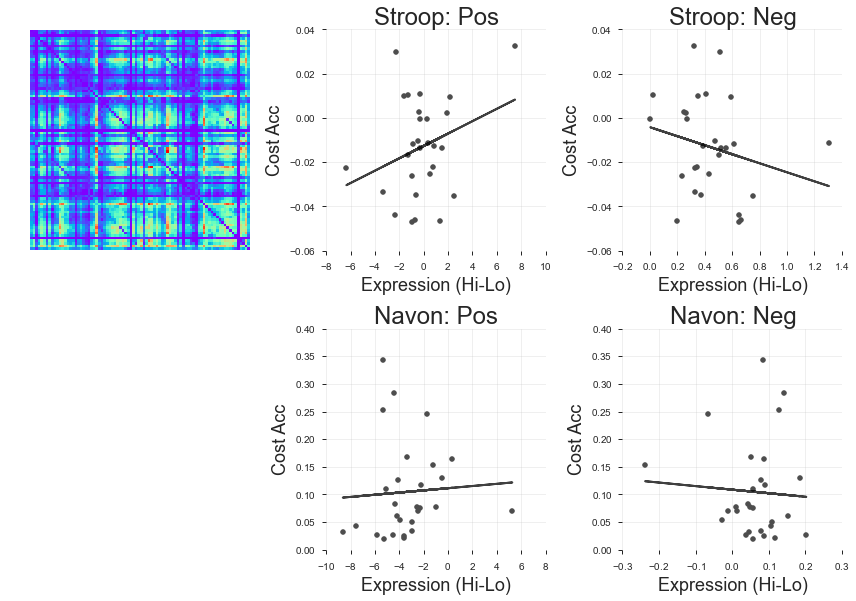





****************************** Subgraph 13 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_pericalcarine
    RH_cuneus
    LH_lingual
    RH_lingual

     Stroop: Pos: rho: -0.18874 pval: 0.17310 sig: 
     Stroop: Neg: rho: 0.19911 pval: 0.16150 sig: 
      Navon: Pos: rho: -0.18552 pval: 0.17940 sig: 
      Navon: Neg: rho: -0.28389 pval: 0.07320 sig: 


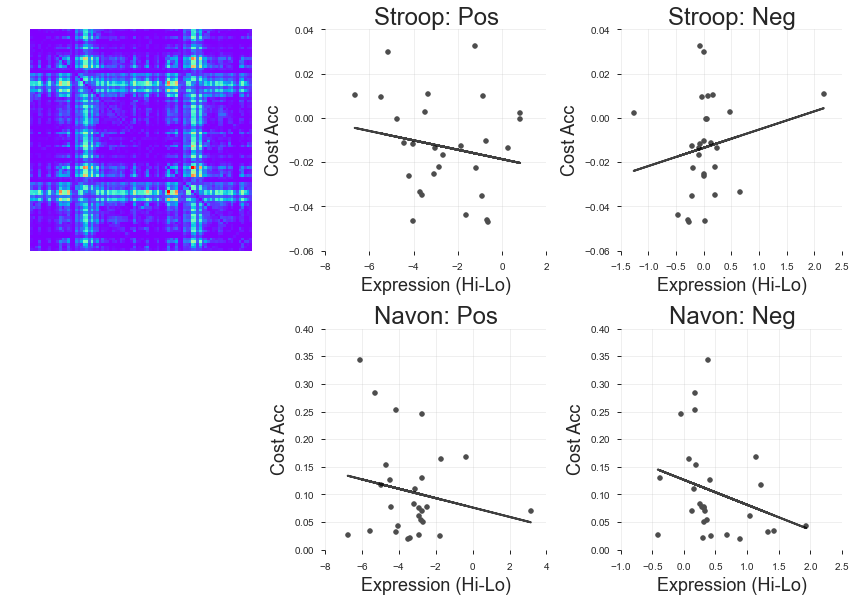





****************************** Subgraph 4 ******************************
    RH_caudalmiddlefrontal
    RH_inferiorparietal
    RH_rostralmiddlefrontal
    RH_parsorbitalis
    LH_lateraloccipital
    RH_middletemporal

     Stroop: Pos: rho: 0.02508 pval: 0.44600 sig: 
     Stroop: Neg: rho: 0.09288 pval: 0.33020 sig: 
      Navon: Pos: rho: 0.23016 pval: 0.12390 sig: 
      Navon: Neg: rho: -0.26042 pval: 0.08890 sig: 


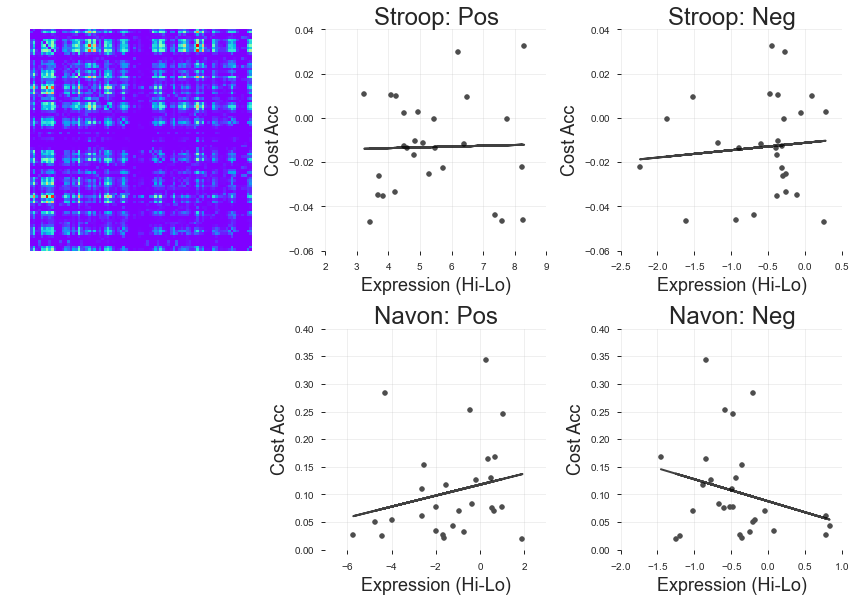





****************************** Subgraph 7 ******************************
    RH_caudalanteriorcingulate
    RH_posteriorcingulate
    LH_posteriorcingulate
    RH_insula
    LH_frontalpole
    RH_isthmuscingulate

     Stroop: Pos: rho: -0.19647 pval: 0.16720 sig: 
     Stroop: Neg: rho: -0.07895 pval: 0.33880 sig: 
      Navon: Pos: rho: 0.26612 pval: 0.08920 sig: 
      Navon: Neg: rho: -0.19494 pval: 0.16160 sig: 


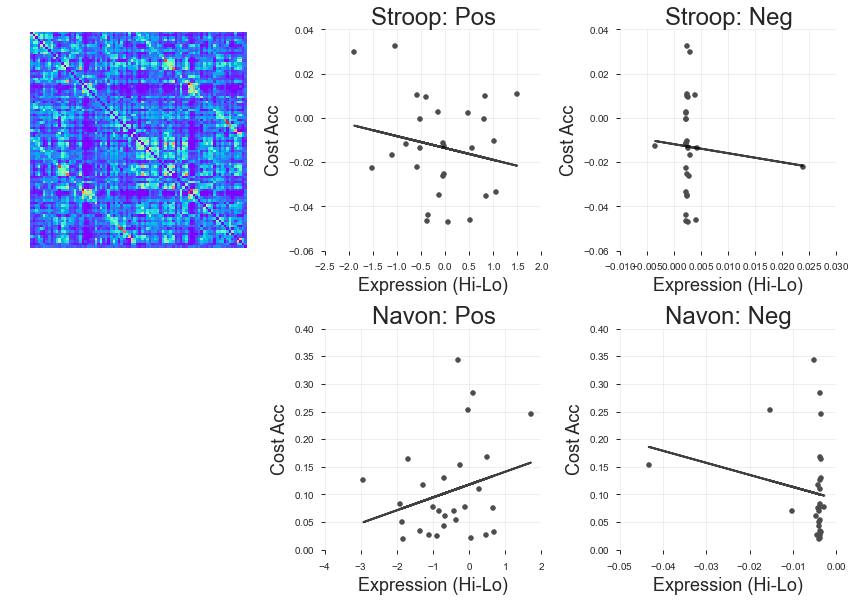





****************************** Subgraph 11 ******************************
    LH_rostralanteriorcingulate
    RH_rostralanteriorcingulate
    LH_frontalpole
    LH_medialorbitofrontal
    LH_lateraloccipital
    RH_lateraloccipital

     Stroop: Pos: rho: 0.10006 pval: 0.30770 sig: 
     Stroop: Neg: rho: 0.05185 pval: 0.39710 sig: 
      Navon: Pos: rho: -0.00824 pval: 0.49830 sig: 
      Navon: Neg: rho: -0.23625 pval: 0.11190 sig: 


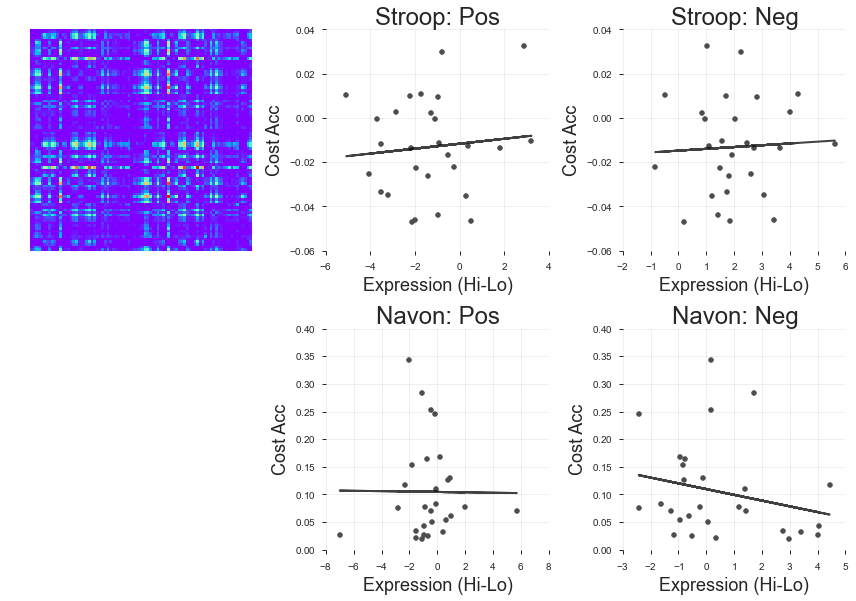





****************************** Subgraph 3 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_cuneus
    LH_lingual
    RH_pericalcarine
    RH_lingual

     Stroop: Pos: rho: 0.10479 pval: 0.30430 sig: 
     Stroop: Neg: rho: -0.08501 pval: 0.34060 sig: 
      Navon: Pos: rho: -0.17340 pval: 0.18840 sig: 
      Navon: Neg: rho: 0.18997 pval: 0.16880 sig: 


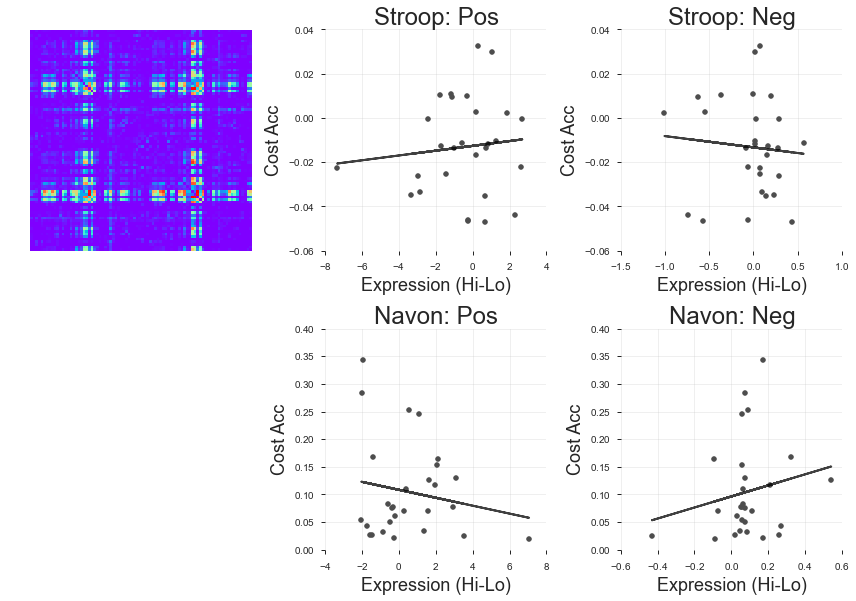





****************************** Subgraph 12 ******************************
    LH_parsorbitalis
    RH_parsorbitalis
    LH_parstriangularis
    LH_middletemporal
    LH_rostralanteriorcingulate
    RH_middletemporal

     Stroop: Pos: rho: -0.08803 pval: 0.32560 sig: 
     Stroop: Neg: rho: -0.13857 pval: 0.25260 sig: 
      Navon: Pos: rho: -0.15376 pval: 0.22390 sig: 
      Navon: Neg: rho: 0.03796 pval: 0.43110 sig: 


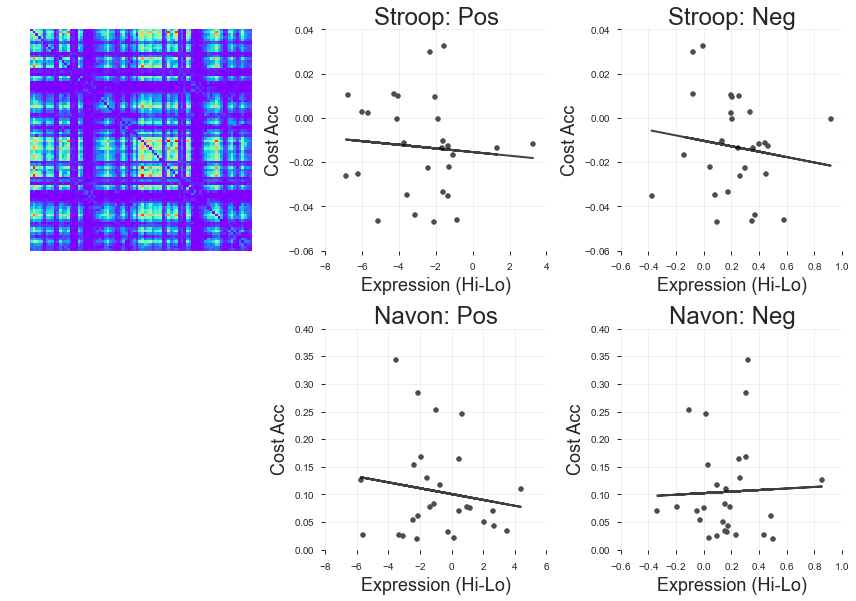





****************************** Subgraph 2 ******************************
    LH_cuneus
    LH_pericalcarine
    RH_posteriorcingulate
    RH_rostralmiddlefrontal
    RH_caudalanteriorcingulate
    LH_caudalanteriorcingulate

     Stroop: Pos: rho: 0.07048 pval: 0.36900 sig: 
     Stroop: Neg: rho: 0.00000 pval: 1.00000 sig: 
      Navon: Pos: rho: -0.13241 pval: 0.24880 sig: 
      Navon: Neg: rho: 0.00000 pval: 1.00000 sig: 


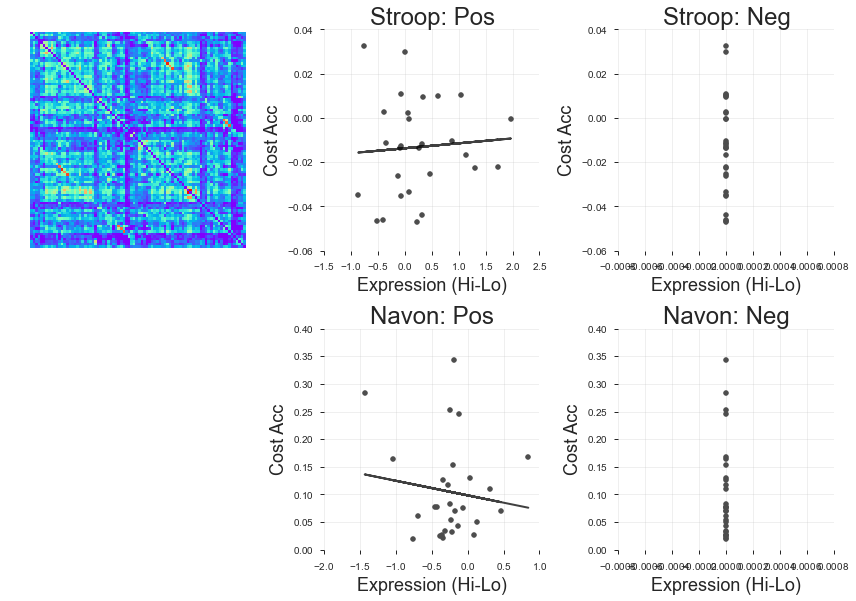





****************************** Subgraph 1 ******************************
    LH_isthmuscingulate
    RH_isthmuscingulate
    LH_precuneus
    RH_precuneus
    LH_parahippocampal
    RH_parahippocampal

     Stroop: Pos: rho: -0.00721 pval: 0.48170 sig: 
     Stroop: Neg: rho: -0.11204 pval: 0.28920 sig: 
      Navon: Pos: rho: -0.00377 pval: 0.49870 sig: 
      Navon: Neg: rho: -0.07138 pval: 0.35620 sig: 


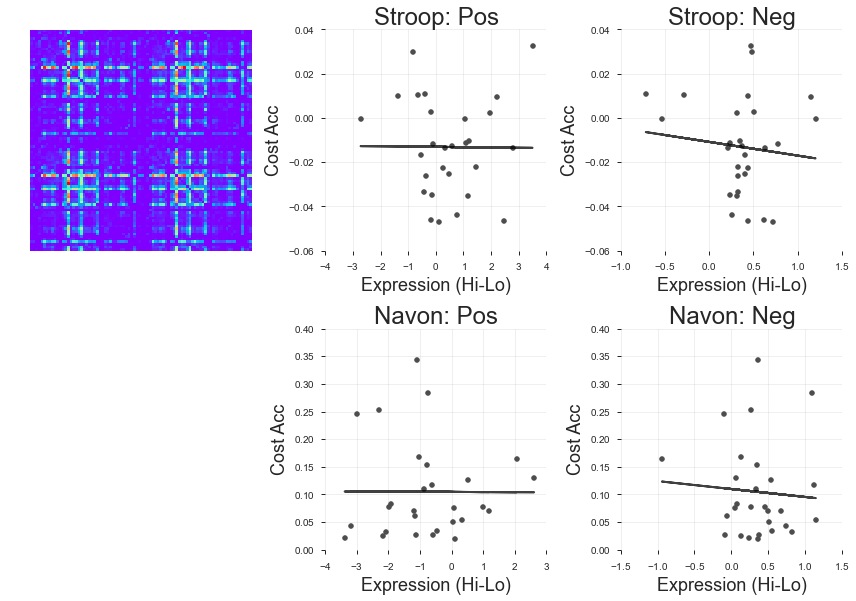





****************************** Subgraph 8 ******************************
    LH_lateraloccipital
    LH_fusiform
    RH_lateraloccipital
    RH_fusiform
    LH_precentral
    LH_superiorparietal

     Stroop: Pos: rho: -0.02118 pval: 0.45810 sig: 
     Stroop: Neg: rho: -0.08694 pval: 0.33410 sig: 
      Navon: Pos: rho: 0.08646 pval: 0.32630 sig: 
      Navon: Neg: rho: -0.06171 pval: 0.37490 sig: 


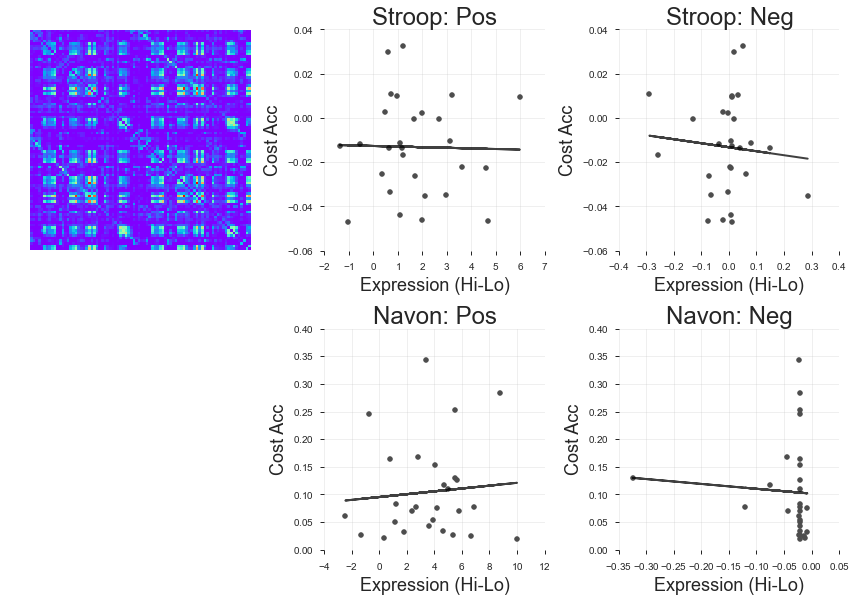

In [61]:
%matplotlib inline

path_cfg_expr = glob.glob('{}/NMF_Optimization.CfgMatr.npz'.format(path_InpData))[0]
df_cfg = np.load(path_cfg_expr, mmap_mode='r')
cfg_key = df_cfg['cfg_key']
key_grp = {'Stroop': {'Pos': ['adj_hi_pos_Stroop', 'adj_lo_pos_Stroop'],
                      'Neg': ['adj_hi_neg_Stroop', 'adj_lo_neg_Stroop']},
           'Navon' : {'Pos': ['adj_hi_pos_Navon', 'adj_lo_pos_Navon'],
                      'Neg': ['adj_hi_neg_Navon', 'adj_lo_neg_Navon']}}
grp_order = ['Stroop', 'Navon']
key_order = ['Pos', 'Neg']
           
beh_grp = {'Stroop': [stroop_move, stroop_cost_acc],
           'Navon': [navon_move, navon_cost_acc]}

sel_fac_ix = np.arange(n_fac)[sel_fac_within_sig]

# Populate plot database
plot_list = []
for fac_ii in sel_fac_ix:
    plot_dict = {'subgraph': conv_cfg_vec_to_adj_matr(bs_fac_subnet[fac_ii, :]),
                 'subplot': []}
                 
    for grp in grp_order: #key_grp.keys():        
        for key in key_order: #key_grp[grp].keys():
            key_hi_ix = np.flatnonzero(cfg_key == key_grp[grp][key][0])
            key_lo_ix = np.flatnonzero(cfg_key == key_grp[grp][key][1])
            
            subj_coef_hi = fac_coef[fac_ii, key_hi_ix].reshape(-1, 6)
            subj_coef_lo = fac_coef[fac_ii, key_lo_ix].reshape(-1, 6)            
            mean_subj_coef = np.mean(subj_coef_hi, axis=1) - np.mean(subj_coef_lo, axis=1)
            
            m, b, _, _, _ = stats.linregress(beh_grp[grp][0], mean_subj_coef)
            real_mean_subj_coef_nomove = mean_subj_coef - beh_grp[grp][0]*m+b
            
            m, b, _, _, _ = stats.linregress(beh_grp[grp][0], beh_grp[grp][1])
            beh_score_nomove = beh_grp[grp][1] - beh_grp[grp][0]*m+b            
            
            real_m, real_b, real_rho, _, _ = stats.linregress(real_mean_subj_coef_nomove, beh_score_nomove)

            if real_rho == 0:
                pval = 1.0
            else:
                n_count = 0
                n_null = 10000
                for rnd_i in xrange(n_null):
                    null_fac_ix = np.random.randint(0, n_fac)
                    null_key_hi_ix = np.random.randint(0, n_obs, size=len(key_hi_ix))
                    null_key_lo_ix = np.random.randint(0, n_obs, size=len(key_lo_ix))
                    
                    subj_coef_hi = null_fac_coef[null_fac_ix, null_key_hi_ix].reshape(-1, 6)
                    subj_coef_lo = null_fac_coef[null_fac_ix, null_key_lo_ix].reshape(-1, 6)
                    mean_subj_coef = np.mean(subj_coef_hi, axis=1) - np.mean(subj_coef_lo, axis=1)

                    m, b, _, _, _ = stats.linregress(beh_grp[grp][0], mean_subj_coef)
                    mean_subj_coef_nomove = mean_subj_coef - beh_grp[grp][0]*m+b

                    m, b, rho, _, _ = stats.linregress(mean_subj_coef_nomove, beh_score_nomove)

                    if (real_rho < 0) & (rho < real_rho):
                        n_count += 1

                    if (real_rho > 0) & (rho > real_rho):
                        n_count += 1

                pval = float(n_count) / float(n_null)                    
            
            subplot_dict = {'title': '{}: {}'.format(grp, key),
                            'xlabel': key,
                            'distrib': (real_mean_subj_coef_nomove, beh_score_nomove),
                            'stats': {}}
            subplot_dict['stats'] = {'rho': real_rho,
                                     'pval': pval,
                                     'slope': real_m,
                                     "interc": real_b,
                                     'sig': ''}       
            
            plot_dict['subplot'].append(subplot_dict)
    plot_list.append(plot_dict)

# Benjamini-Hochberg Multiple Comparisons
all_pval = np.sort([fac_subp['stats']['pval']
                    for fac_plot in plot_list
                    for fac_subp in fac_plot['subplot']])[::-1]
alpha = 0.05
n_comp = len(all_pval)
for ix, i in enumerate(range(n_comp, 0, -1)):
    adj_alpha = i/n_comp*alpha
    if all_pval[ix] < adj_alpha:
        break
print('%0.10f' % adj_alpha)        

# Re-adjust significant indicator and re-order subgraphs
min_fac_pval = []
for fac_plot in plot_list:
    pval_list = []
    for fac_subp in fac_plot['subplot']:
        if fac_subp['stats']['pval'] < adj_alpha:
            fac_subp['stats']['sig'] = '*'
        pval_list.append(fac_subp['stats']['pval'])
    min_fac_pval.append(np.min(pval_list))
sel_fac_ord = np.argsort(min_fac_pval)

# Plot each result
for fac_ix in sel_fac_ord:
    fac_plot = plot_list[fac_ix]
    
    plt.figure(figsize=(12,12))
    ax = plt.subplot(3, 3, 1)
    ax.matshow(fac_plot['subgraph'], cmap='rainbow')
    ax.set_axis_off()
    ax_list = [2,3,5,6]

    print('****************************** Subgraph {} ******************************'.format(fac_ix+1))    
    sort_roi = np.argsort(np.sum(fac_plot['subgraph'], axis=0))[::-1]
    print('    ' + '\n    '.join([all_roi_names[sort_roi[i]] for i in xrange(6)]))
    print('')

    for subp_ii, fac_subp in enumerate(fac_plot['subplot']):
        ax = plt.subplot(3, 3, ax_list[subp_ii])
        
        ax.plot(fac_subp['distrib'][0], 
                fac_subp['stats']['slope']*fac_subp['distrib'][0]+fac_subp['stats']['interc'],
                color='k', alpha=0.75)
        ax.scatter(fac_subp['distrib'][0], fac_subp['distrib'][1],
                   color=[0.3, 0.3, 0.3])

        ax.set_xlabel('Expression (Hi-Lo)')
        ax.set_ylabel('Cost Acc')
        ax.set_title(fac_subp['title'])
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')


        print('    %12s: rho: %3.5f pval: %3.5f sig: %s' % 
              (fac_subp['title'],
               fac_subp['stats']['rho'],
               fac_subp['stats']['pval'],
               fac_subp['stats']['sig']))
            
    plt.show()
    print('\n\n\n')